<a href="https://colab.research.google.com/github/seba6029/LMHAI/blob/main/LMHSS23_AAI_Week1_Ex2_Sebastian_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Can you generate faces?
##### We expect you to use images to generate new ones with a Generative Model of your choice. You have to write a dataloader to read images from the folder 'cropped/', write a Generative Model class, a loss function, a training loop, and visualize your generated images.

In [2]:
import os
import torch
import torch.nn as nn
import matplotlib.image as mpimg
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Lambda

from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np

%matplotlib inline

### Nothing to change here (This cell downloads and unzips the data).

In [3]:
!wget https://www.dropbox.com/s/g0w7a3x1aw3oonf/SimpsonFaces.zip?dl=0

!unzip SimpsonFaces.zip?dl=0

!ls

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: __MACOSX/cropped/._4084.png  
  inflating: cropped/3933.png        
  inflating: __MACOSX/cropped/._3933.png  
  inflating: cropped/2393.png        
  inflating: __MACOSX/cropped/._2393.png  
  inflating: cropped/1842.png        
  inflating: __MACOSX/cropped/._1842.png  
  inflating: cropped/4912.png        
  inflating: __MACOSX/cropped/._4912.png  
  inflating: cropped/326.png         
  inflating: __MACOSX/cropped/._326.png  
  inflating: cropped/440.png         
  inflating: __MACOSX/cropped/._440.png  
  inflating: cropped/9588.png        
  inflating: __MACOSX/cropped/._9588.png  
  inflating: cropped/8696.png        
  inflating: __MACOSX/cropped/._8696.png  
  inflating: cropped/6863.png        
  inflating: __MACOSX/cropped/._6863.png  
  inflating: cropped/454.png         
  inflating: __MACOSX/cropped/._454.png  
  inflating: cropped/8682.png        
  inflating: __MACOSX/cropped/._8682.png  
  inflat

## Dataloader
####  Write a dataloader to read images from the folder 'cropped/' (Note that the transform *trans* resizes the images to 32x32)

In [4]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([32,32])])

batch_size = 64

class MyDataset(Dataset):
  def __init__(self, image_path, transform = trans):
    self.image_path = image_path
    self.images = os.listdir(image_path)
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    im = self.images[idx]
    im = mpimg.imread(os.path.join(self.image_path, im))
    im = self.transform(im)
    return im

In [5]:
dataset = MyDataset("/content/cropped")

train_loader = DataLoader(dataset, batch_size = batch_size)

#### Visualize the data
##### Get a batch from the dataloader and visualize its images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dataloader output shape:  torch.Size([64, 3, 32, 32])


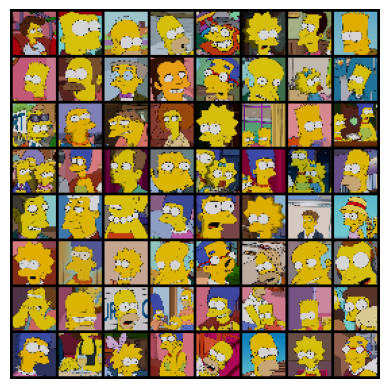

In [6]:
# Make sure our data loader has outputs right shape
data_iter = next(iter(train_loader))
print('Dataloader output shape: ', data_iter.size())

# Visualizing sample images from one batch
from torchvision.utils import make_grid
samples = data_iter
grid_img = make_grid(samples, nrow=8)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Generative Model class
#### Write a Generative Model class in the following cell

In [7]:
EPOCHS = 100
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
Z = 100

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# ADD CODE HERE
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)


def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
  """Generator model"""
  def __init__(self, z):
    super(Generator, self).__init__()
    self.z = z
    self.gen_model = nn.Sequential(
        nn.Linear(z, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(),

        nn.Linear(64, 64 * 4 * 4),
        nn.BatchNorm1d(64 * 4 * 4),
        nn.LeakyReLU(),

        Reshape((-1,64,4,4)),

        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Tanh(),
    )

  def forward(self, x):
    x = self.gen_model(x)
    return x


class Discriminator(nn.Module):
  """Discriminator model"""
  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Flatten(1,-1),
        nn.Linear(64 * 4 * 4, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    x = self.disc_model(x)
    return x


generator = Generator(z=Z)
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (disc_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=128, out_features=1, bias=True)
    (14): Sigmoid()
  )
)

In [10]:
# Generator summary
summary(generator, (Z,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           6,464
       BatchNorm1d-2                   [-1, 64]             128
         LeakyReLU-3                   [-1, 64]               0
            Linear-4                 [-1, 1024]          66,560
       BatchNorm1d-5                 [-1, 1024]           2,048
         LeakyReLU-6                 [-1, 1024]               0
           Reshape-7             [-1, 64, 4, 4]               0
   ConvTranspose2d-8             [-1, 32, 7, 7]          18,464
       BatchNorm2d-9             [-1, 32, 7, 7]              64
        LeakyReLU-10             [-1, 32, 7, 7]               0
  ConvTranspose2d-11           [-1, 16, 14, 14]           4,624
      BatchNorm2d-12           [-1, 16, 14, 14]              32
        LeakyReLU-13           [-1, 16, 14, 14]               0
  ConvTranspose2d-14            [-1, 3,

In [11]:
# Discriminator summary
summary(discriminator, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
       BatchNorm2d-2           [-1, 16, 16, 16]              32
         LeakyReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           4,640
       BatchNorm2d-5             [-1, 32, 8, 8]              64
         LeakyReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                  [-1, 128]         131,200
      BatchNorm1d-12                  [-1, 128]             256
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                   

## Loss
#### Define Loss function in the following cell

In [12]:
# ADD CODE HERE
# Defining the optimizer and loss function here
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [13]:

real_label = 1
fake_label = 0

In [14]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.reshape(28,28,3))
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

### Training Loop
#### Define optimizer, write the training loop in the following cell, and plot the loss

Epoch 1/100: : 100%|██████████| 155/155 [00:27<00:00,  5.69it/s, generator_loss=0.783, discriminator_loss=1.35, D(x)=0.511, D(G(z1))=0.486, D(G(z2))=0.458]


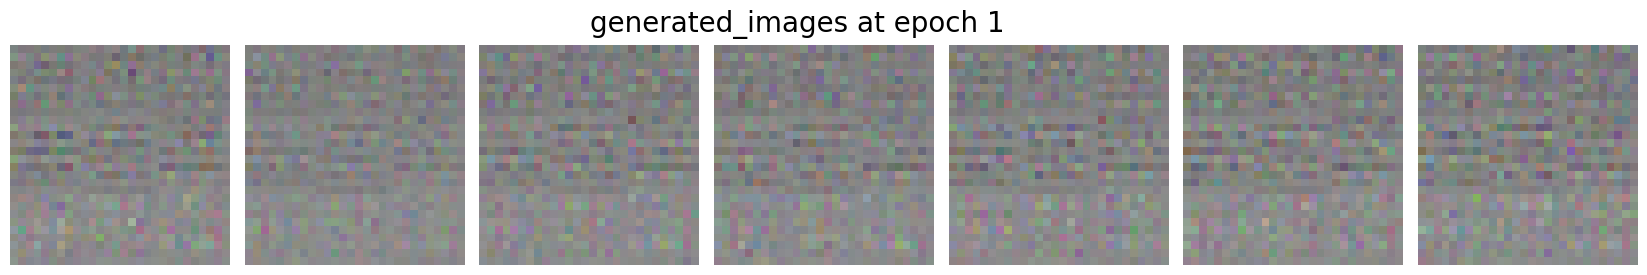

Epoch 2/100: : 100%|██████████| 155/155 [00:24<00:00,  6.34it/s, generator_loss=0.997, discriminator_loss=1.18, D(x)=0.541, D(G(z1))=0.417, D(G(z2))=0.374]


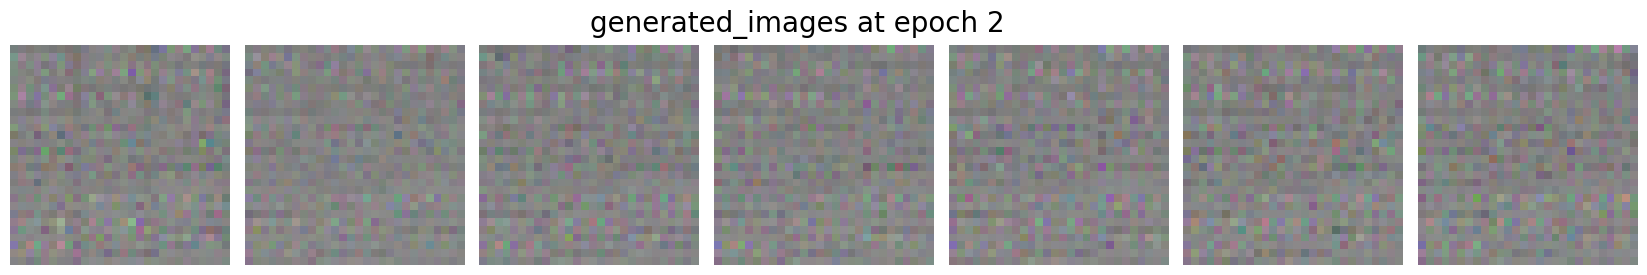

Epoch 3/100: : 100%|██████████| 155/155 [00:24<00:00,  6.40it/s, generator_loss=1.23, discriminator_loss=0.909, D(x)=0.615, D(G(z1))=0.331, D(G(z2))=0.295]


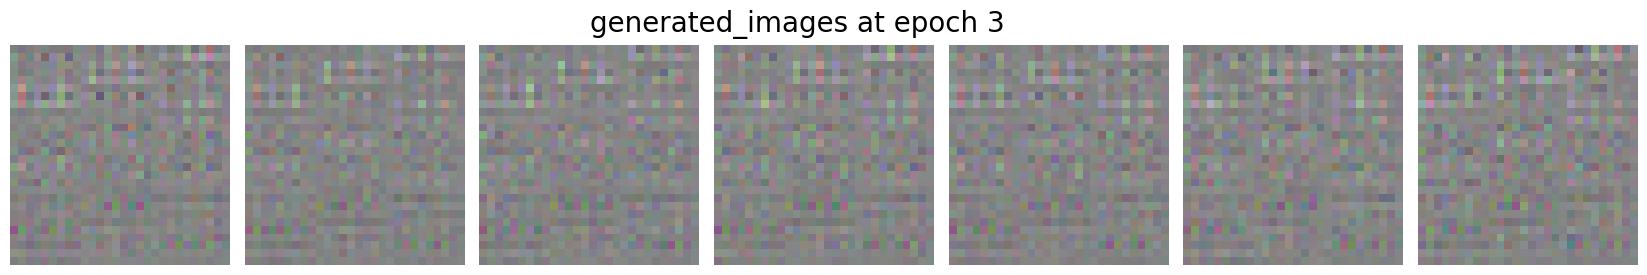

Epoch 4/100: : 100%|██████████| 155/155 [00:24<00:00,  6.32it/s, generator_loss=1.56, discriminator_loss=0.678, D(x)=0.699, D(G(z1))=0.259, D(G(z2))=0.214]


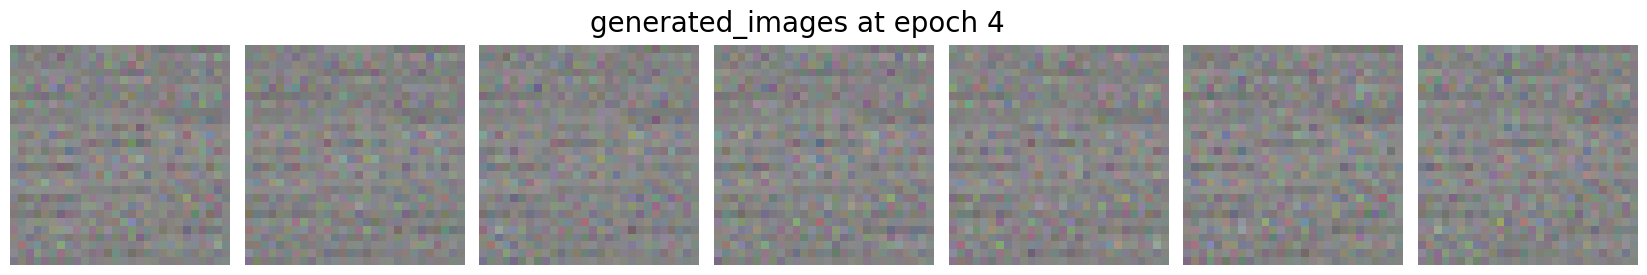

Epoch 5/100: : 100%|██████████| 155/155 [00:24<00:00,  6.22it/s, generator_loss=1.81, discriminator_loss=0.467, D(x)=0.795, D(G(z1))=0.202, D(G(z2))=0.165]


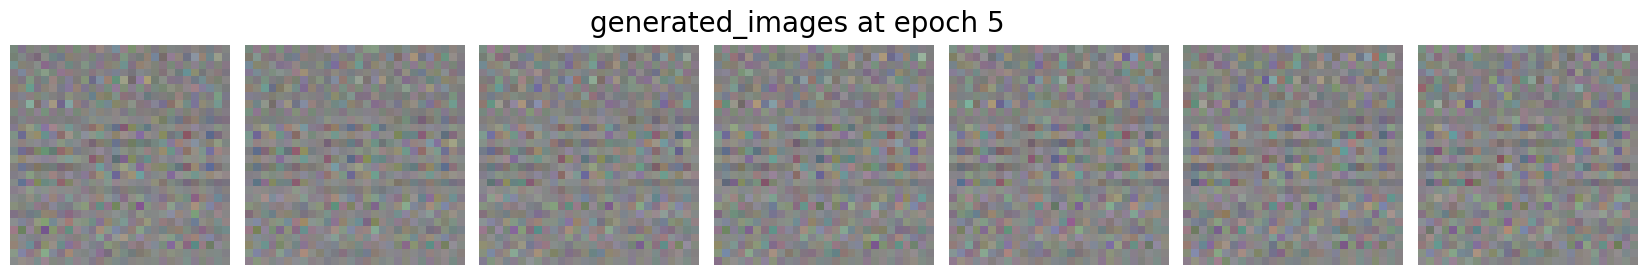

Epoch 6/100: : 100%|██████████| 155/155 [00:24<00:00,  6.28it/s, generator_loss=2.19, discriminator_loss=0.335, D(x)=0.851, D(G(z1))=0.154, D(G(z2))=0.115]


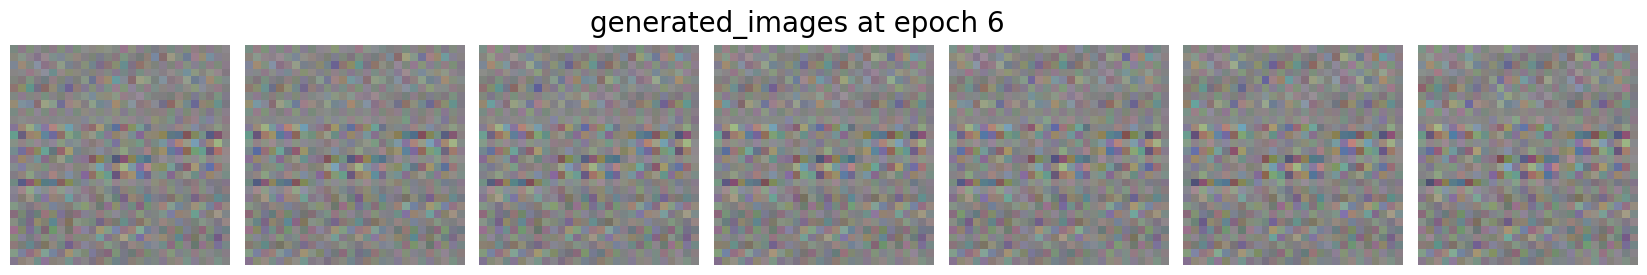

Epoch 7/100: : 100%|██████████| 155/155 [00:25<00:00,  6.16it/s, generator_loss=2.48, discriminator_loss=0.252, D(x)=0.878, D(G(z1))=0.11, D(G(z2))=0.0853]


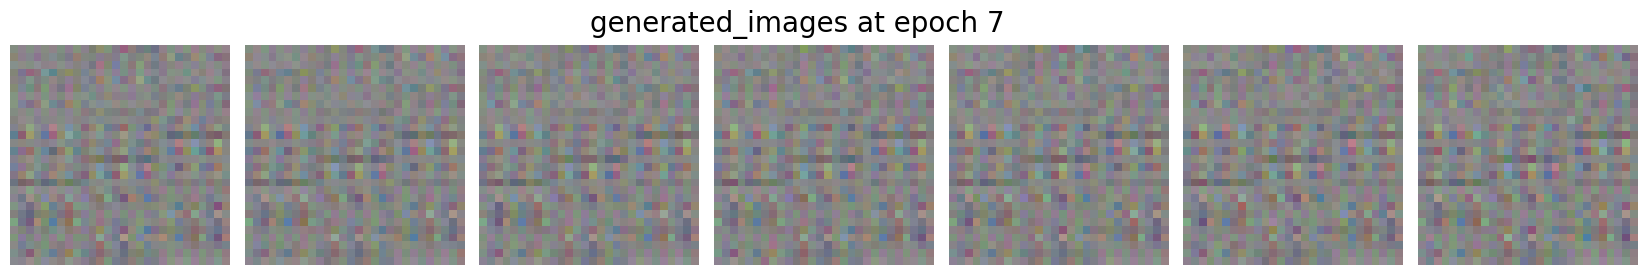

Epoch 8/100: : 100%|██████████| 155/155 [00:25<00:00,  6.13it/s, generator_loss=2.76, discriminator_loss=0.198, D(x)=0.906, D(G(z1))=0.0911, D(G(z2))=0.068]


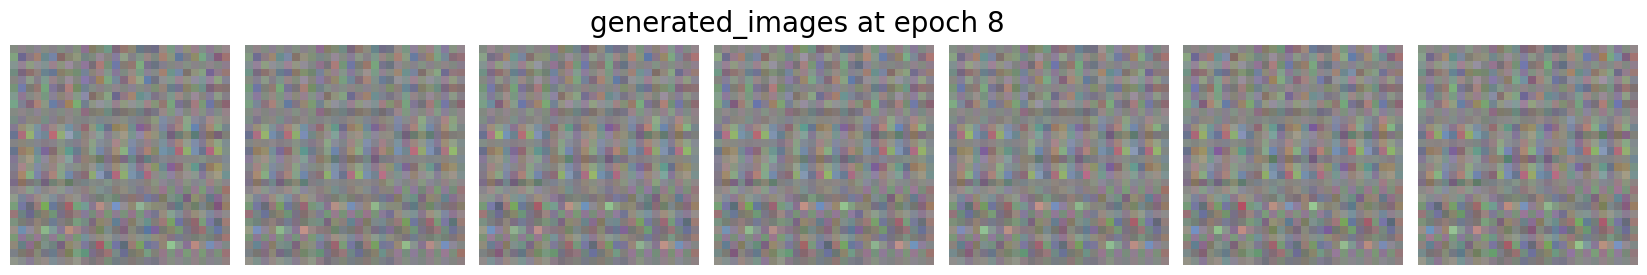

Epoch 9/100: : 100%|██████████| 155/155 [00:25<00:00,  6.12it/s, generator_loss=3.02, discriminator_loss=0.152, D(x)=0.916, D(G(z1))=0.0611, D(G(z2))=0.0504]


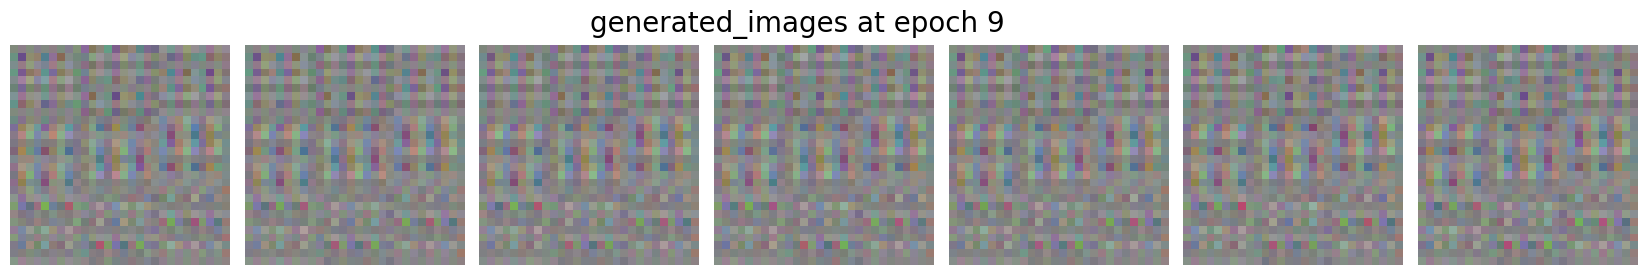

Epoch 10/100: : 100%|██████████| 155/155 [00:25<00:00,  6.09it/s, generator_loss=3.23, discriminator_loss=0.127, D(x)=0.934, D(G(z1))=0.0562, D(G(z2))=0.0421]


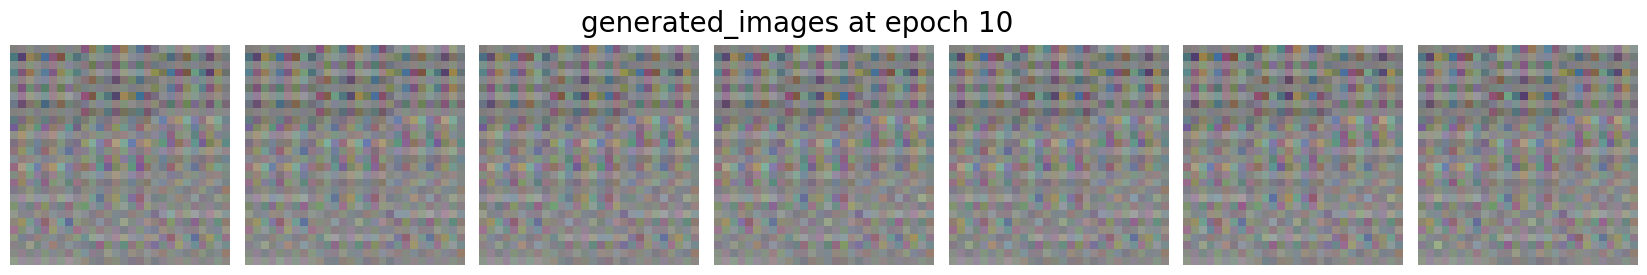

Epoch 11/100: : 100%|██████████| 155/155 [00:25<00:00,  5.97it/s, generator_loss=3.21, discriminator_loss=0.279, D(x)=0.856, D(G(z1))=0.104, D(G(z2))=0.0477]


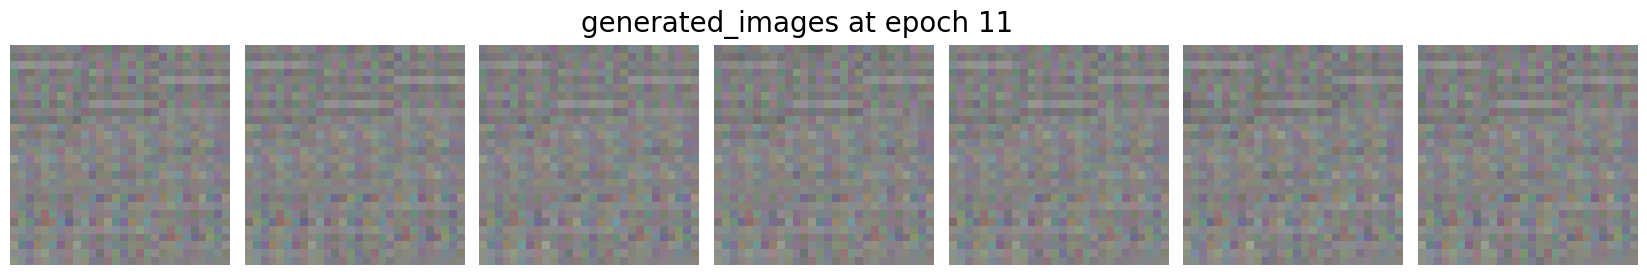

Epoch 12/100: : 100%|██████████| 155/155 [00:25<00:00,  6.01it/s, generator_loss=3.51, discriminator_loss=0.109, D(x)=0.946, D(G(z1))=0.0512, D(G(z2))=0.0325]


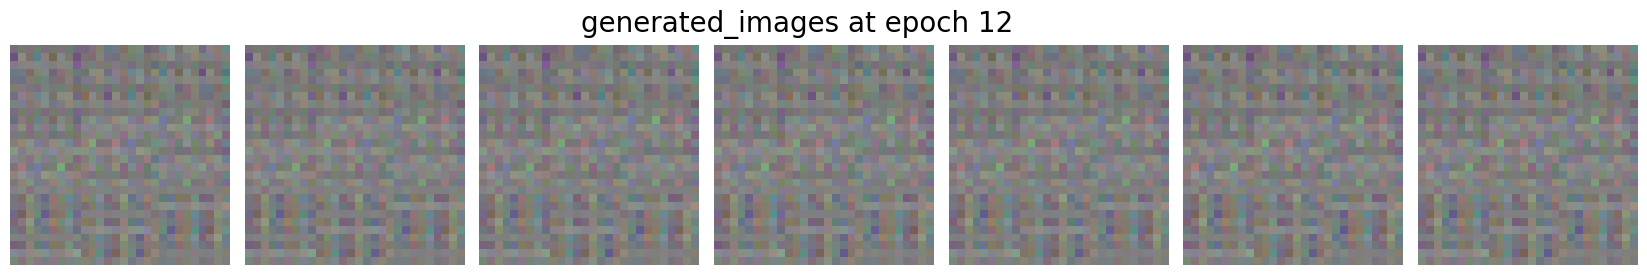

Epoch 13/100: : 100%|██████████| 155/155 [00:25<00:00,  6.00it/s, generator_loss=3.71, discriminator_loss=0.089, D(x)=0.953, D(G(z1))=0.0397, D(G(z2))=0.0275]


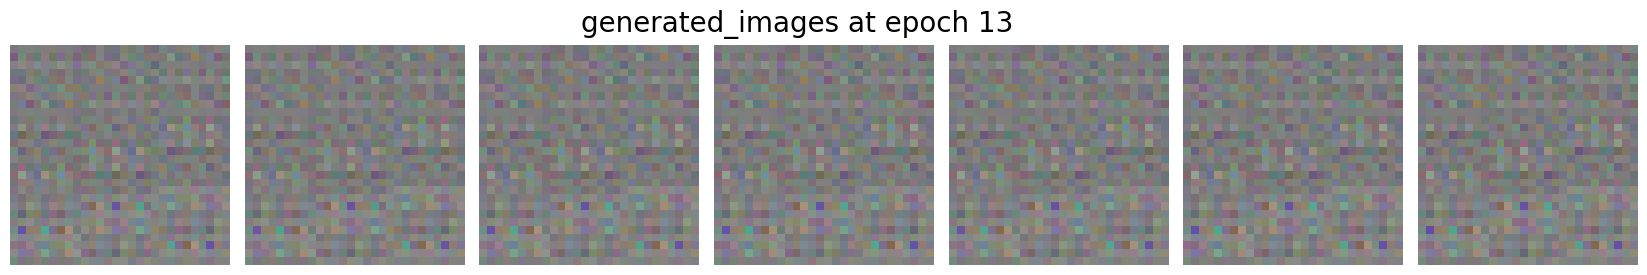

Epoch 14/100: : 100%|██████████| 155/155 [00:26<00:00,  5.91it/s, generator_loss=3.89, discriminator_loss=0.0759, D(x)=0.96, D(G(z1))=0.034, D(G(z2))=0.0234]


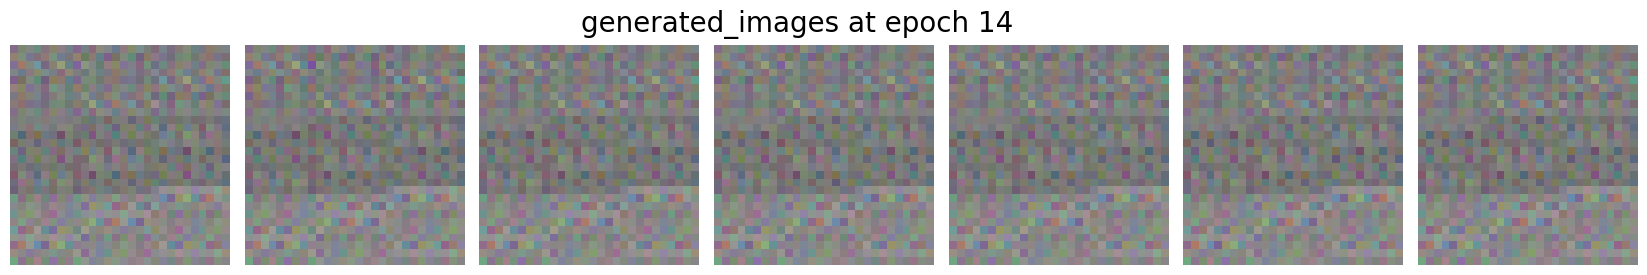

Epoch 15/100: : 100%|██████████| 155/155 [00:26<00:00,  5.95it/s, generator_loss=4.17, discriminator_loss=0.0655, D(x)=0.963, D(G(z1))=0.0265, D(G(z2))=0.0189]


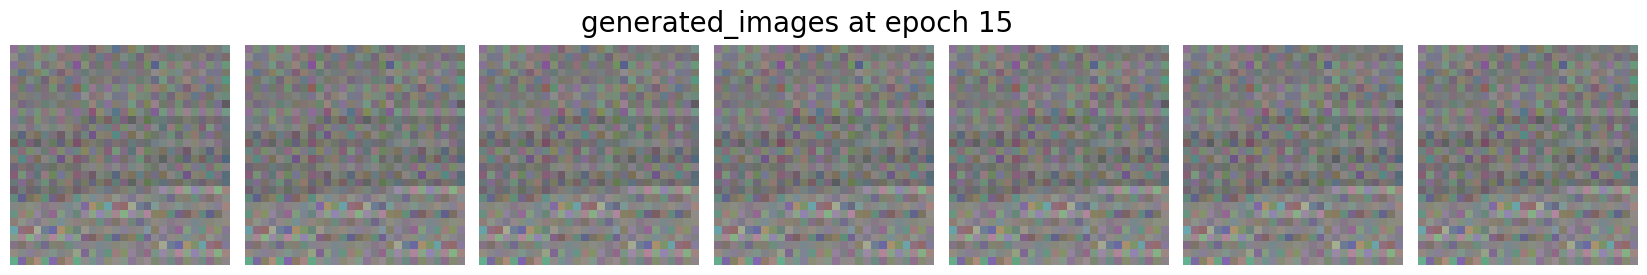

Epoch 16/100: : 100%|██████████| 155/155 [00:26<00:00,  5.79it/s, generator_loss=4.28, discriminator_loss=0.0558, D(x)=0.967, D(G(z1))=0.0218, D(G(z2))=0.0162]


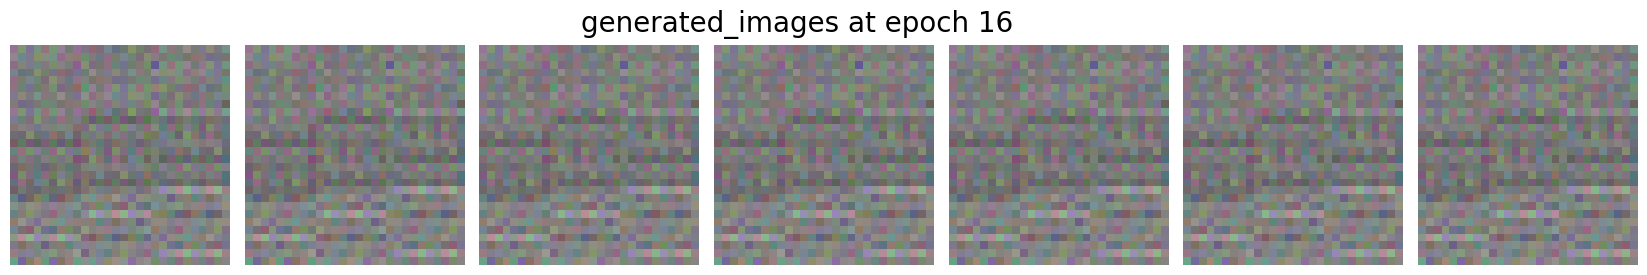

Epoch 17/100: : 100%|██████████| 155/155 [00:26<00:00,  5.93it/s, generator_loss=4.62, discriminator_loss=0.0607, D(x)=0.964, D(G(z1))=0.0237, D(G(z2))=0.0143]


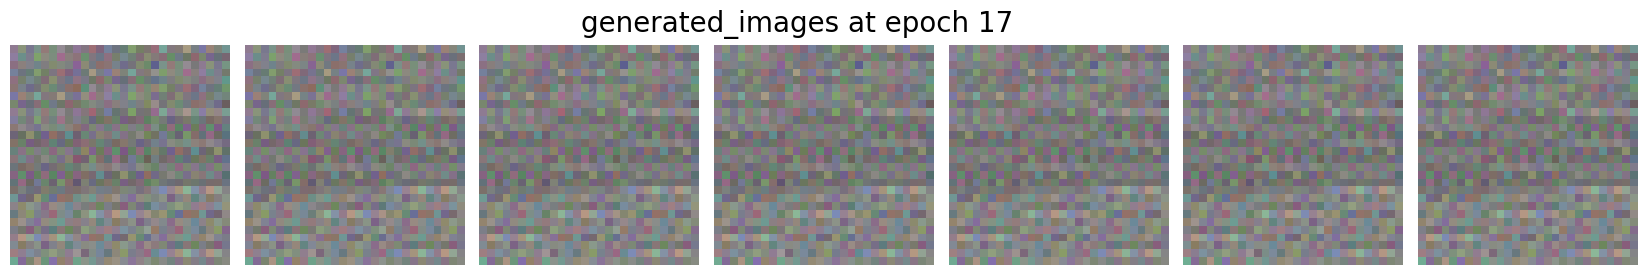

Epoch 18/100: : 100%|██████████| 155/155 [00:26<00:00,  5.91it/s, generator_loss=4.55, discriminator_loss=0.0523, D(x)=0.971, D(G(z1))=0.0219, D(G(z2))=0.012]


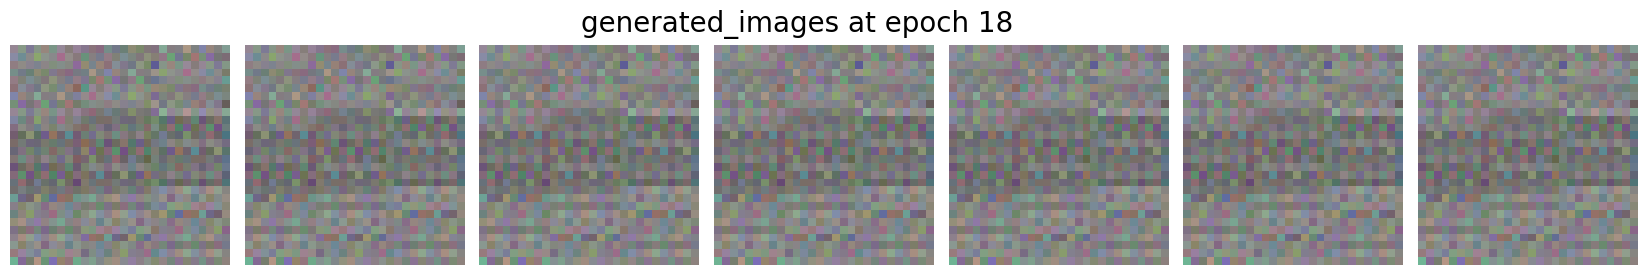

Epoch 19/100: : 100%|██████████| 155/155 [00:26<00:00,  5.88it/s, generator_loss=4.78, discriminator_loss=0.0681, D(x)=0.967, D(G(z1))=0.0336, D(G(z2))=0.0201]


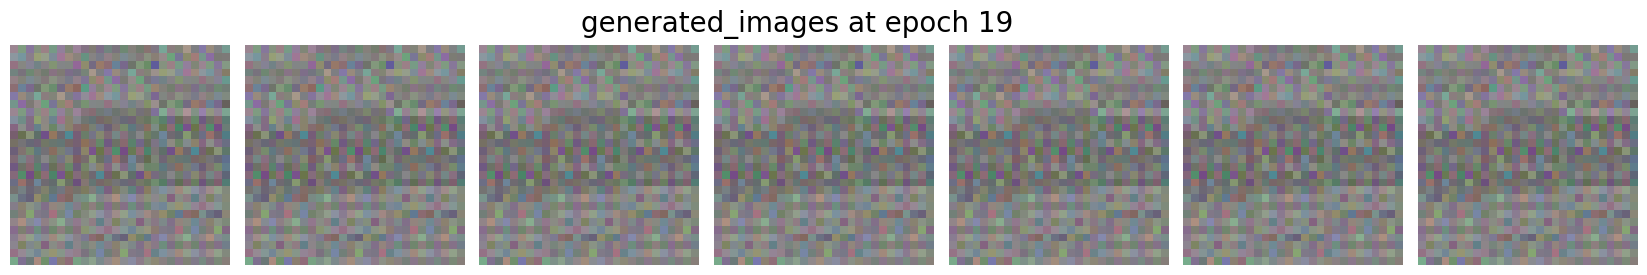

Epoch 20/100: : 100%|██████████| 155/155 [00:26<00:00,  5.85it/s, generator_loss=4.79, discriminator_loss=0.083, D(x)=0.943, D(G(z1))=0.0228, D(G(z2))=0.0129]


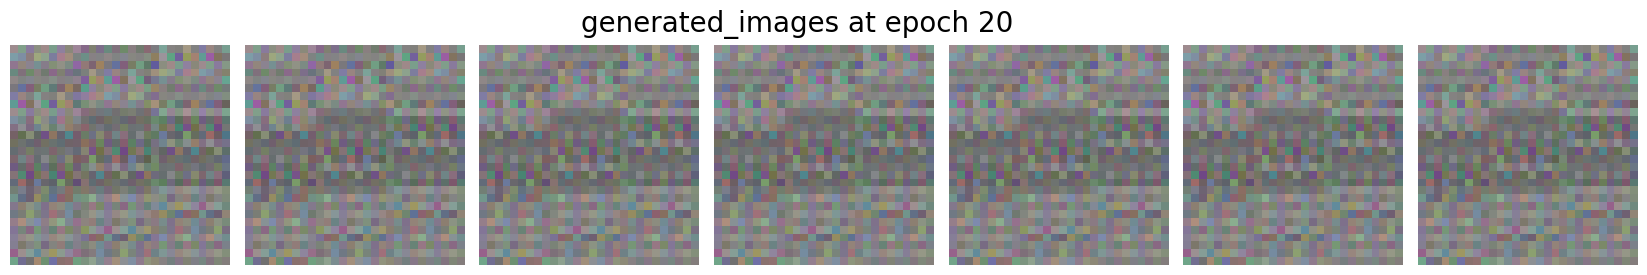

Epoch 21/100: : 100%|██████████| 155/155 [00:26<00:00,  5.87it/s, generator_loss=4.16, discriminator_loss=0.129, D(x)=0.934, D(G(z1))=0.0529, D(G(z2))=0.0195]


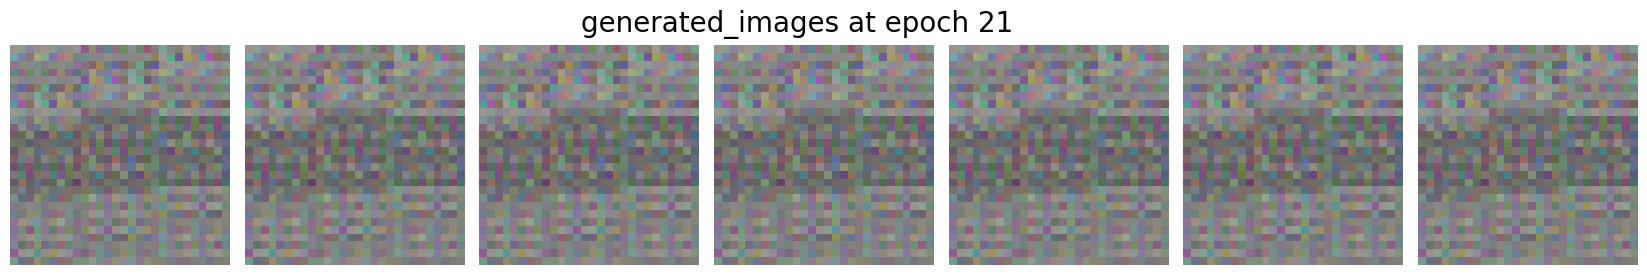

Epoch 22/100: : 100%|██████████| 155/155 [00:26<00:00,  5.84it/s, generator_loss=4.29, discriminator_loss=0.134, D(x)=0.926, D(G(z1))=0.0505, D(G(z2))=0.0231]


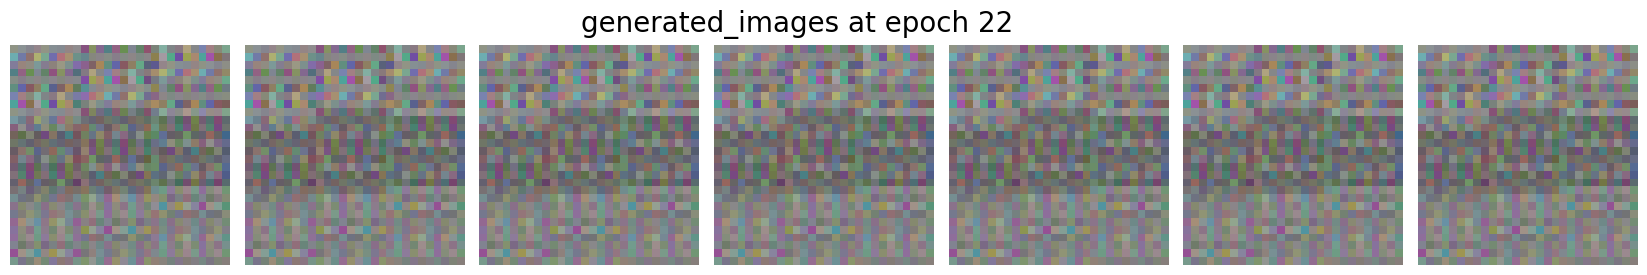

Epoch 23/100: : 100%|██████████| 155/155 [00:26<00:00,  5.80it/s, generator_loss=4.02, discriminator_loss=0.0995, D(x)=0.936, D(G(z1))=0.0313, D(G(z2))=0.0261]


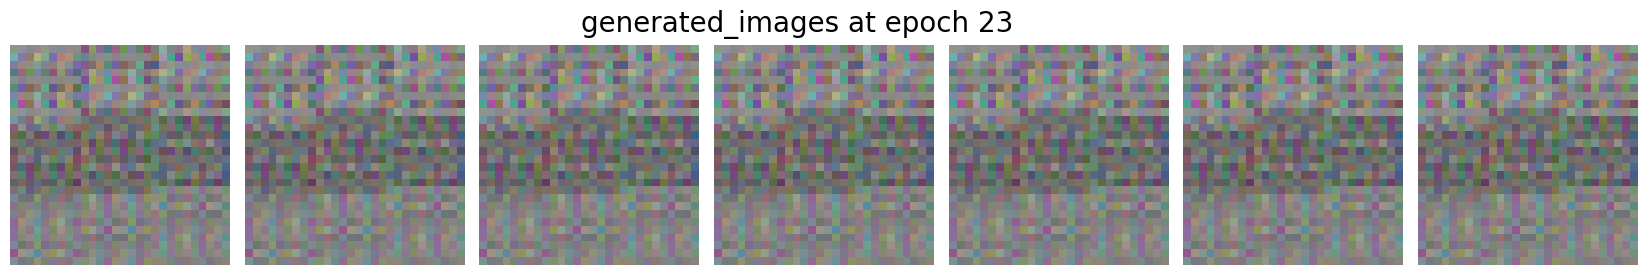

Epoch 24/100: : 100%|██████████| 155/155 [00:27<00:00,  5.66it/s, generator_loss=4.32, discriminator_loss=0.143, D(x)=0.92, D(G(z1))=0.0528, D(G(z2))=0.0407]


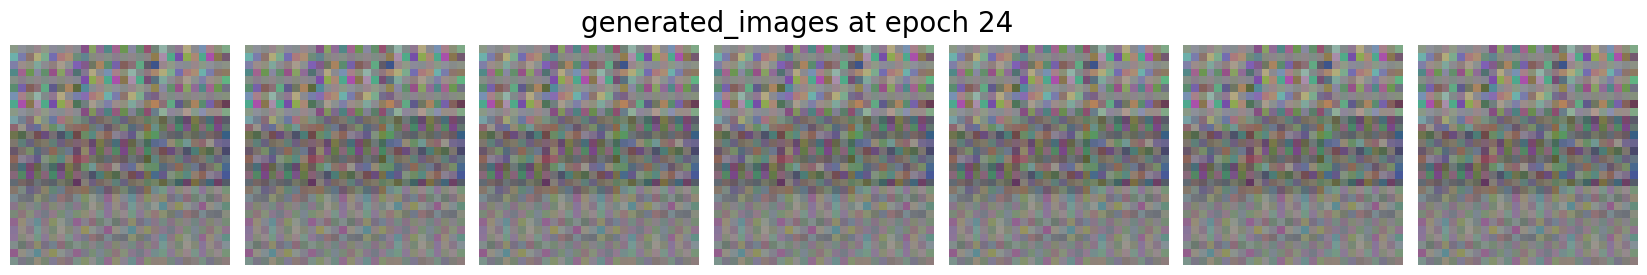

Epoch 25/100: : 100%|██████████| 155/155 [00:27<00:00,  5.70it/s, generator_loss=3.63, discriminator_loss=0.123, D(x)=0.938, D(G(z1))=0.0544, D(G(z2))=0.0344]


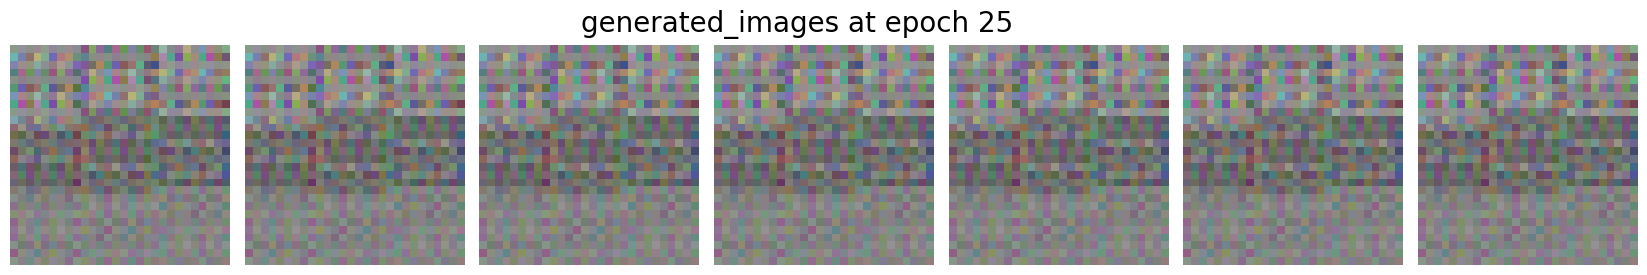

Epoch 26/100: : 100%|██████████| 155/155 [00:27<00:00,  5.73it/s, generator_loss=3.78, discriminator_loss=0.0882, D(x)=0.955, D(G(z1))=0.0391, D(G(z2))=0.0291]


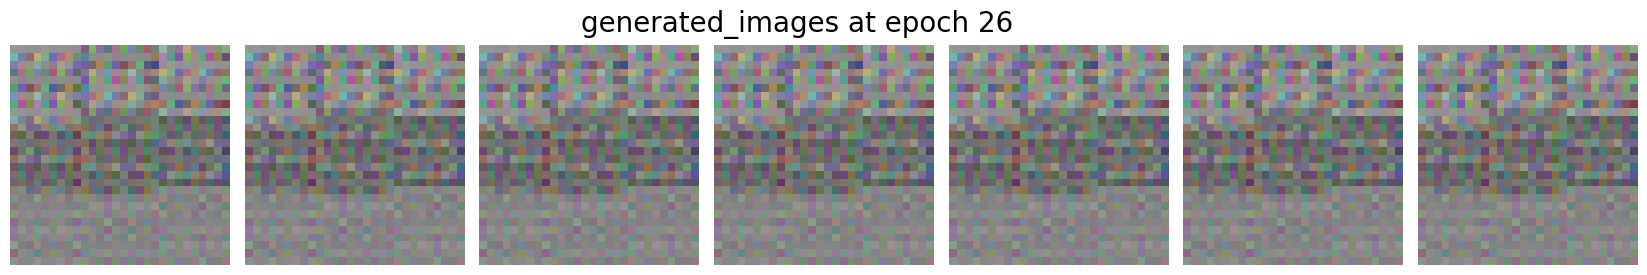

Epoch 27/100: : 100%|██████████| 155/155 [00:27<00:00,  5.68it/s, generator_loss=4.08, discriminator_loss=0.0804, D(x)=0.956, D(G(z1))=0.0337, D(G(z2))=0.0298]


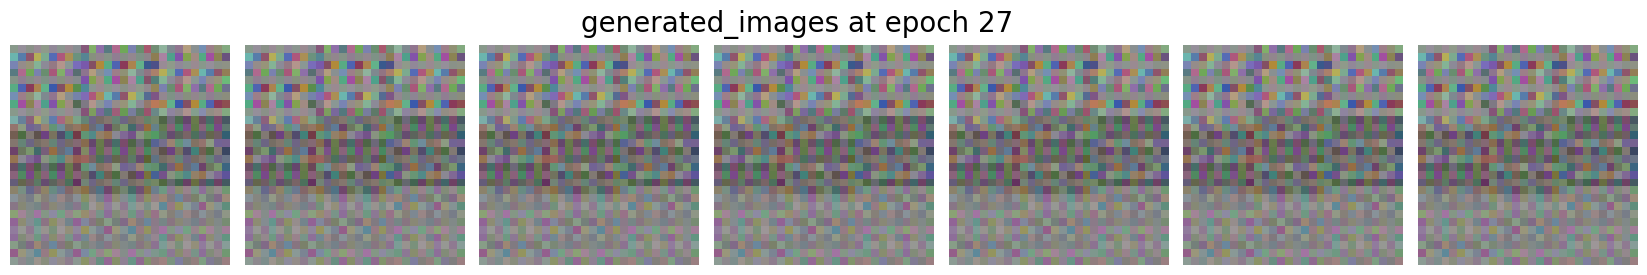

Epoch 28/100: : 100%|██████████| 155/155 [00:27<00:00,  5.72it/s, generator_loss=4.57, discriminator_loss=0.116, D(x)=0.934, D(G(z1))=0.0374, D(G(z2))=0.0308]


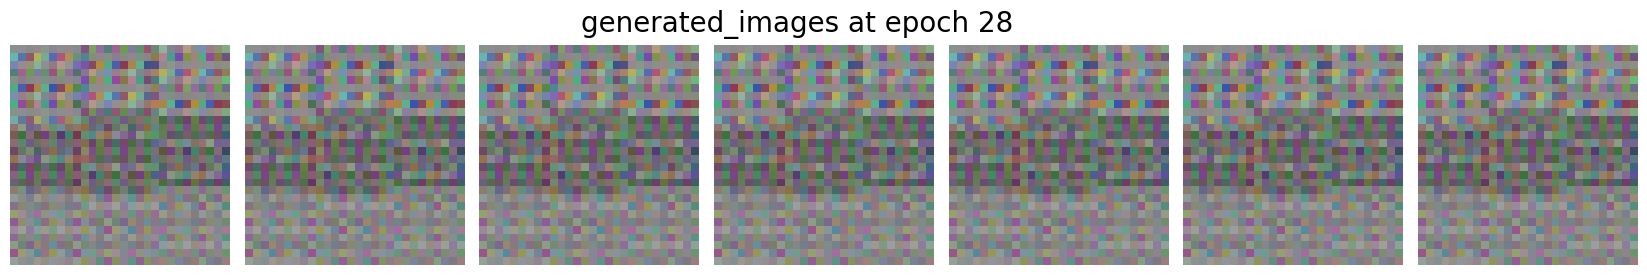

Epoch 29/100: : 100%|██████████| 155/155 [00:27<00:00,  5.71it/s, generator_loss=4.97, discriminator_loss=0.0755, D(x)=0.945, D(G(z1))=0.0174, D(G(z2))=0.0156]


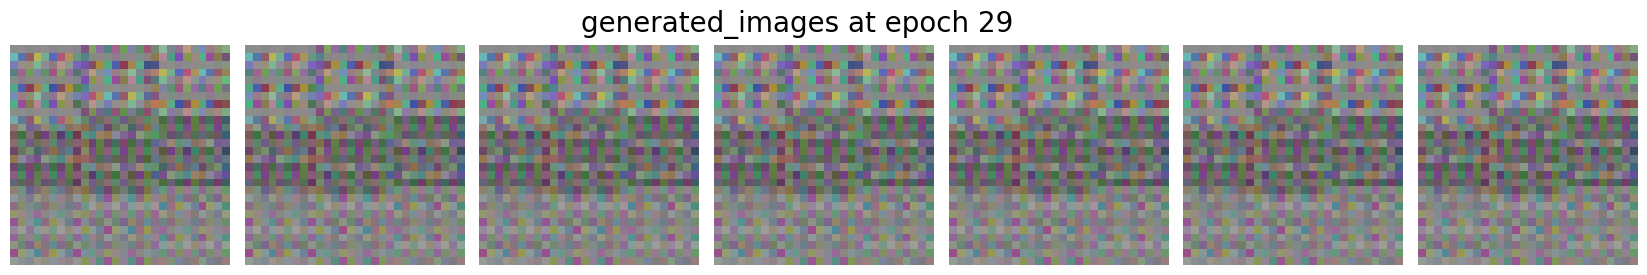

Epoch 30/100: : 100%|██████████| 155/155 [00:27<00:00,  5.74it/s, generator_loss=4.37, discriminator_loss=0.0745, D(x)=0.964, D(G(z1))=0.0357, D(G(z2))=0.0307]


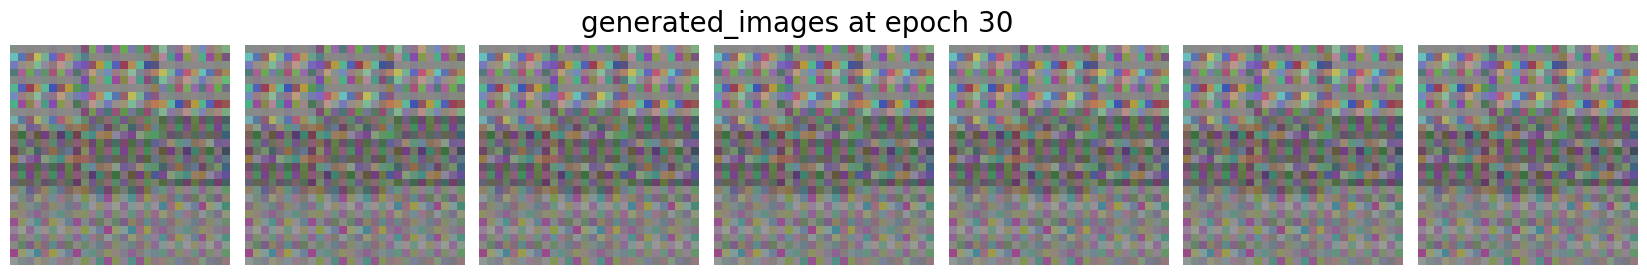

Epoch 31/100: : 100%|██████████| 155/155 [00:27<00:00,  5.72it/s, generator_loss=4.92, discriminator_loss=0.0427, D(x)=0.97, D(G(z1))=0.0123, D(G(z2))=0.0116]


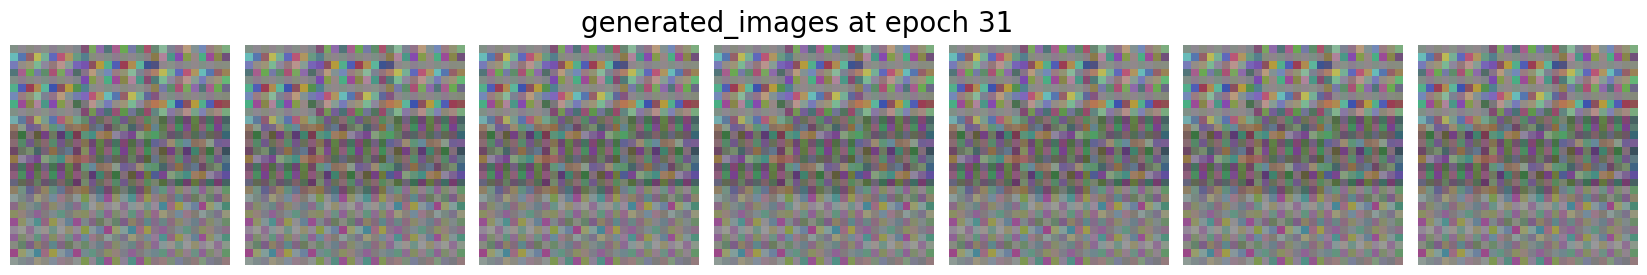

Epoch 32/100: : 100%|██████████| 155/155 [00:27<00:00,  5.73it/s, generator_loss=4.27, discriminator_loss=0.043, D(x)=0.979, D(G(z1))=0.0218, D(G(z2))=0.0206]


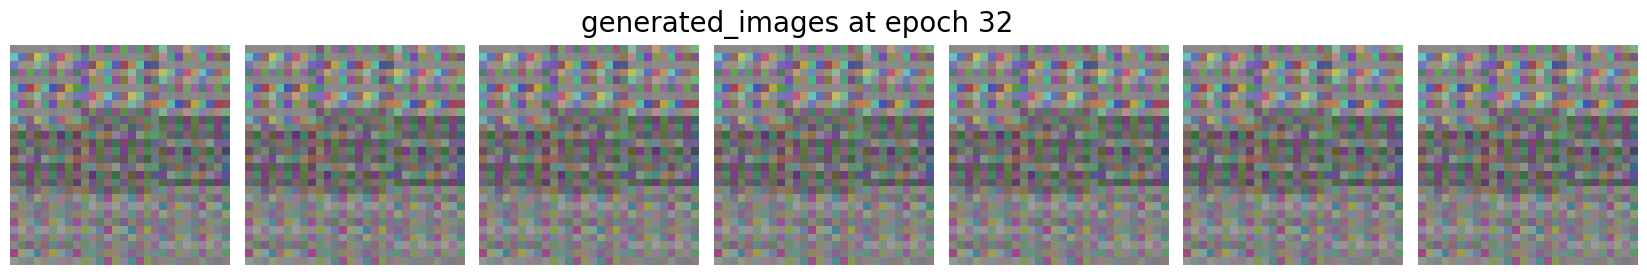

Epoch 33/100: : 100%|██████████| 155/155 [00:28<00:00,  5.52it/s, generator_loss=4.66, discriminator_loss=0.0309, D(x)=0.981, D(G(z1))=0.0116, D(G(z2))=0.0111]


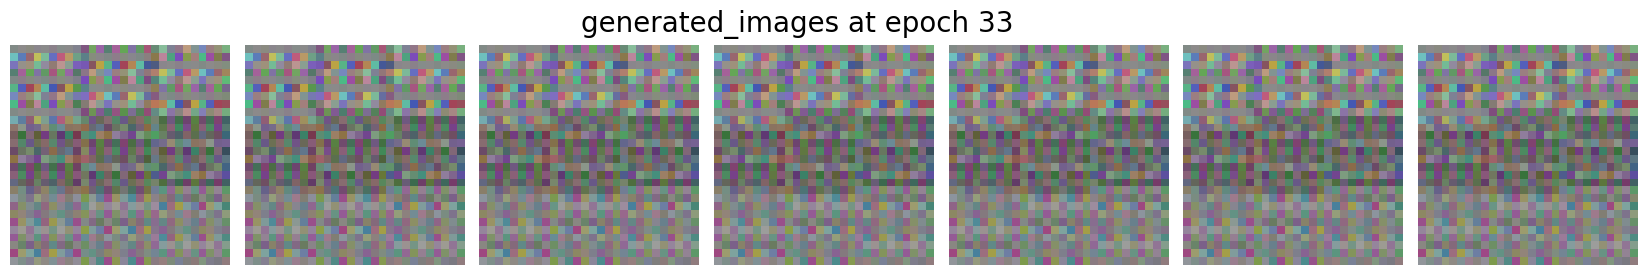

Epoch 34/100: : 100%|██████████| 155/155 [00:27<00:00,  5.68it/s, generator_loss=5.1, discriminator_loss=0.0294, D(x)=0.984, D(G(z1))=0.0131, D(G(z2))=0.0121]


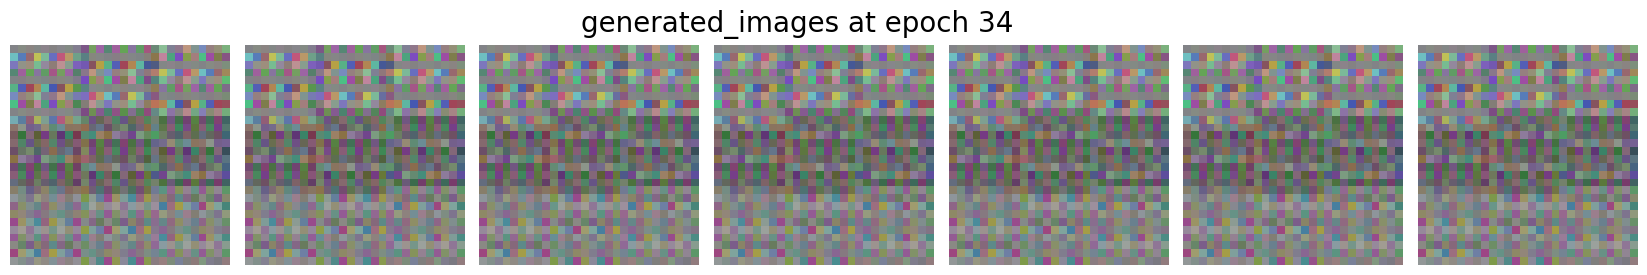

Epoch 35/100: : 100%|██████████| 155/155 [00:27<00:00,  5.65it/s, generator_loss=5.61, discriminator_loss=0.0275, D(x)=0.985, D(G(z1))=0.012, D(G(z2))=0.0103]


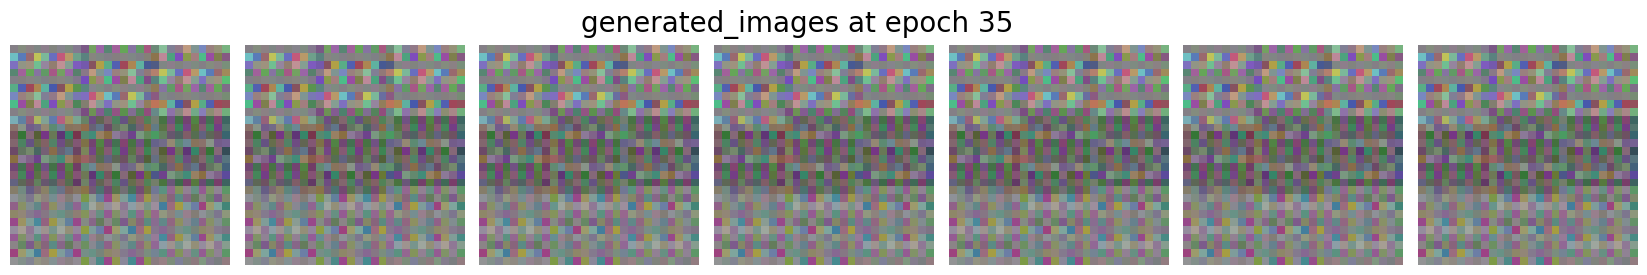

Epoch 36/100: : 100%|██████████| 155/155 [00:27<00:00,  5.64it/s, generator_loss=6.39, discriminator_loss=0.0259, D(x)=0.984, D(G(z1))=0.0094, D(G(z2))=0.00912]


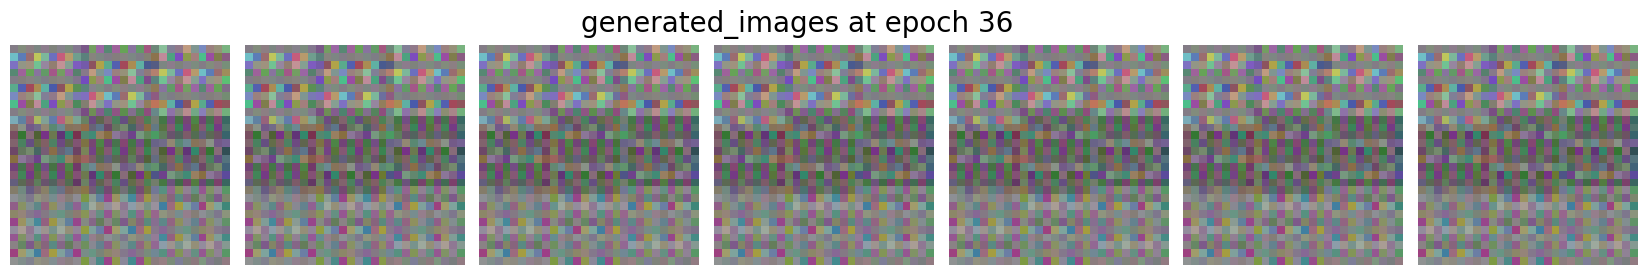

Epoch 37/100: : 100%|██████████| 155/155 [00:27<00:00,  5.63it/s, generator_loss=6.04, discriminator_loss=0.0212, D(x)=0.988, D(G(z1))=0.00926, D(G(z2))=0.00896]


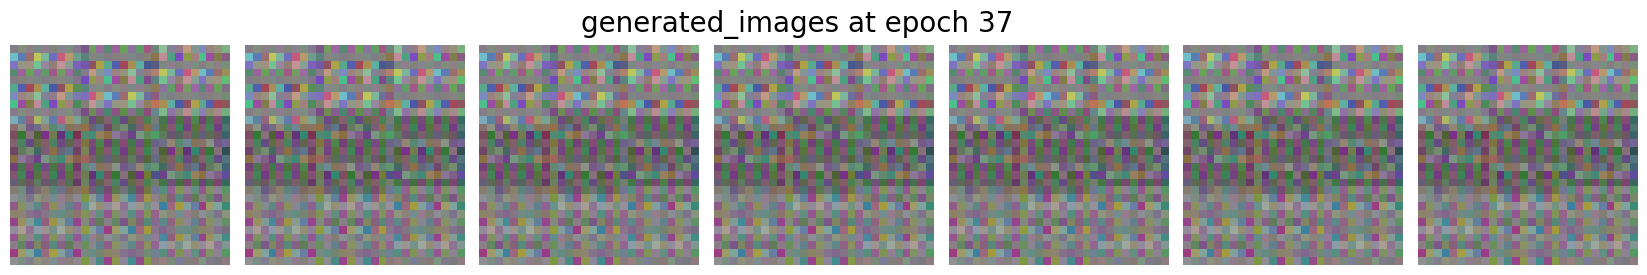

Epoch 38/100: : 100%|██████████| 155/155 [00:27<00:00,  5.59it/s, generator_loss=7.03, discriminator_loss=0.0178, D(x)=0.988, D(G(z1))=0.00515, D(G(z2))=0.00467]


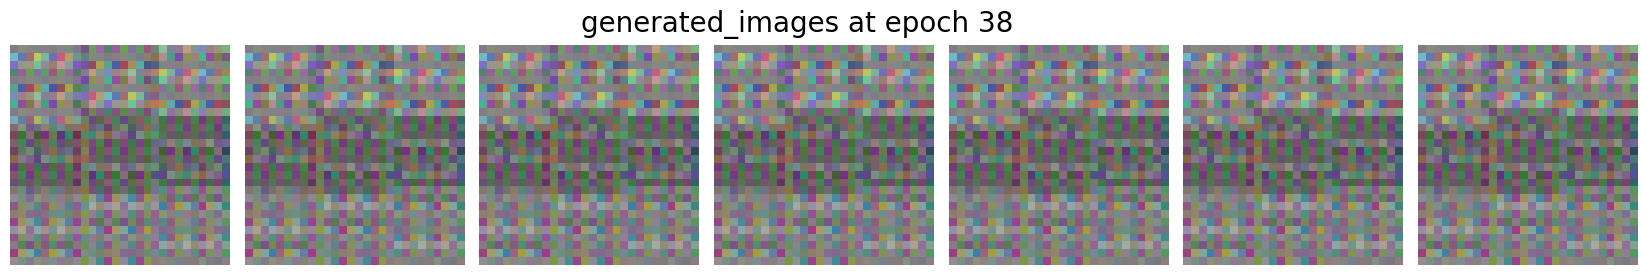

Epoch 39/100: : 100%|██████████| 155/155 [00:27<00:00,  5.62it/s, generator_loss=4.99, discriminator_loss=0.0181, D(x)=0.992, D(G(z1))=0.00955, D(G(z2))=0.00899]


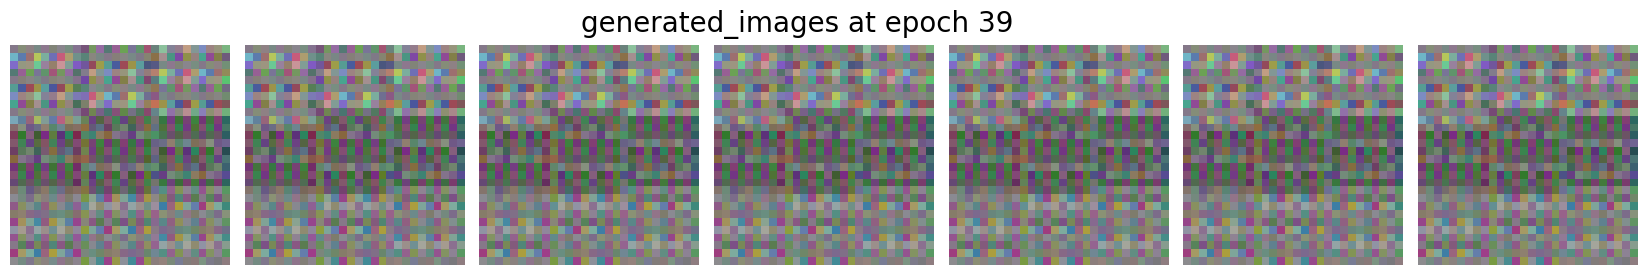

Epoch 40/100: : 100%|██████████| 155/155 [00:27<00:00,  5.59it/s, generator_loss=7.33, discriminator_loss=0.0121, D(x)=0.993, D(G(z1))=0.00488, D(G(z2))=0.00478]


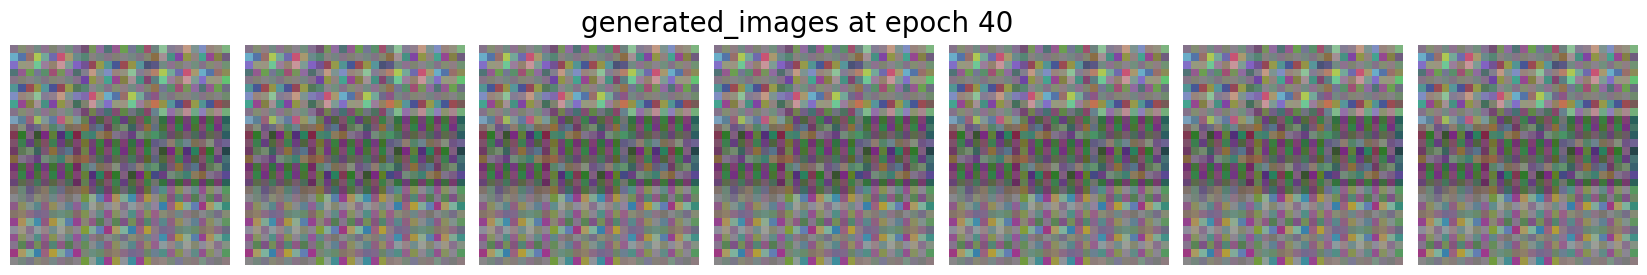

Epoch 41/100: : 100%|██████████| 155/155 [00:28<00:00,  5.48it/s, generator_loss=7.61, discriminator_loss=0.00917, D(x)=0.995, D(G(z1))=0.00398, D(G(z2))=0.00374]


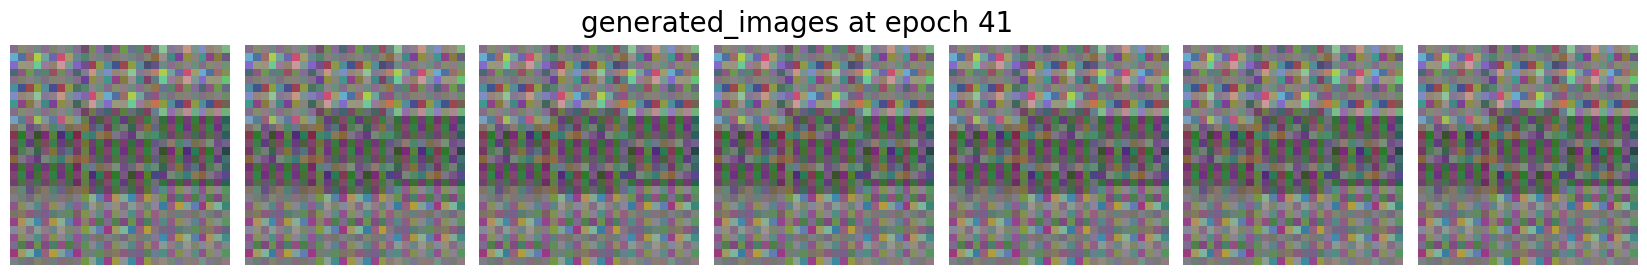

Epoch 42/100: : 100%|██████████| 155/155 [00:28<00:00,  5.53it/s, generator_loss=5.09, discriminator_loss=0.0138, D(x)=0.995, D(G(z1))=0.00882, D(G(z2))=0.00772]


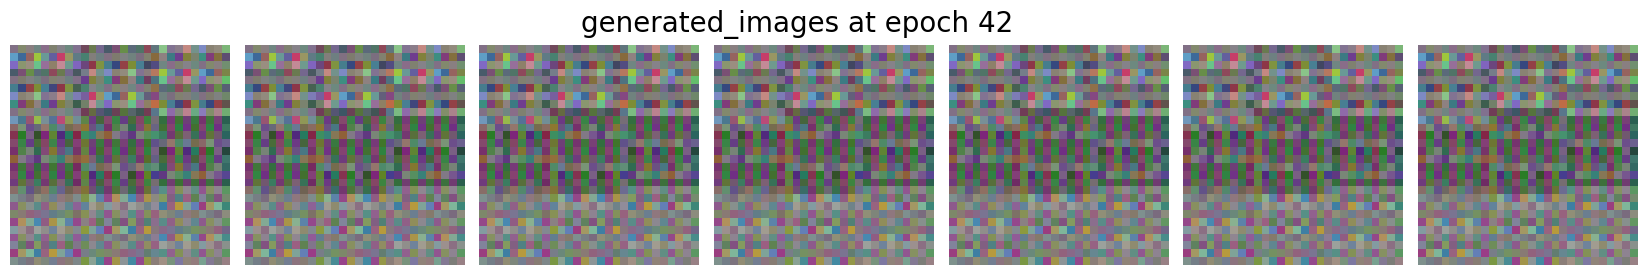

Epoch 43/100: : 100%|██████████| 155/155 [00:27<00:00,  5.61it/s, generator_loss=7.78, discriminator_loss=0.00485, D(x)=0.996, D(G(z1))=0.000754, D(G(z2))=0.000738]


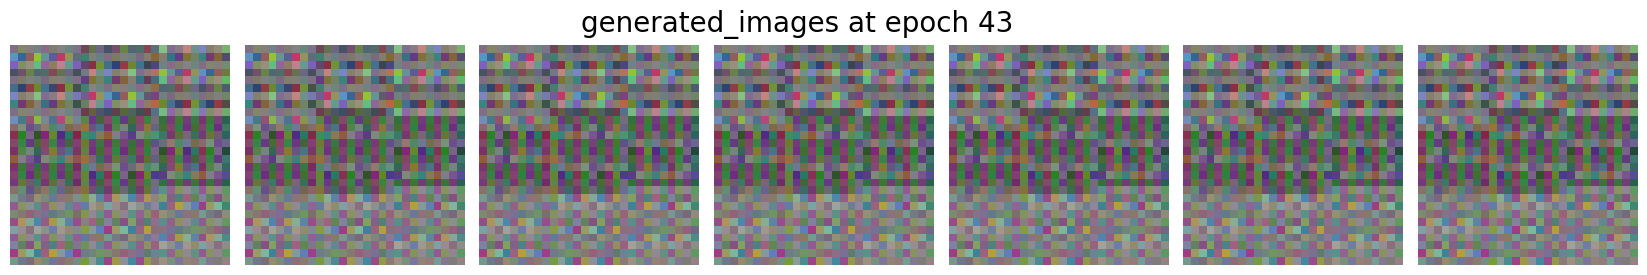

Epoch 44/100: : 100%|██████████| 155/155 [00:28<00:00,  5.53it/s, generator_loss=5.94, discriminator_loss=0.00847, D(x)=0.996, D(G(z1))=0.0043, D(G(z2))=0.00394]


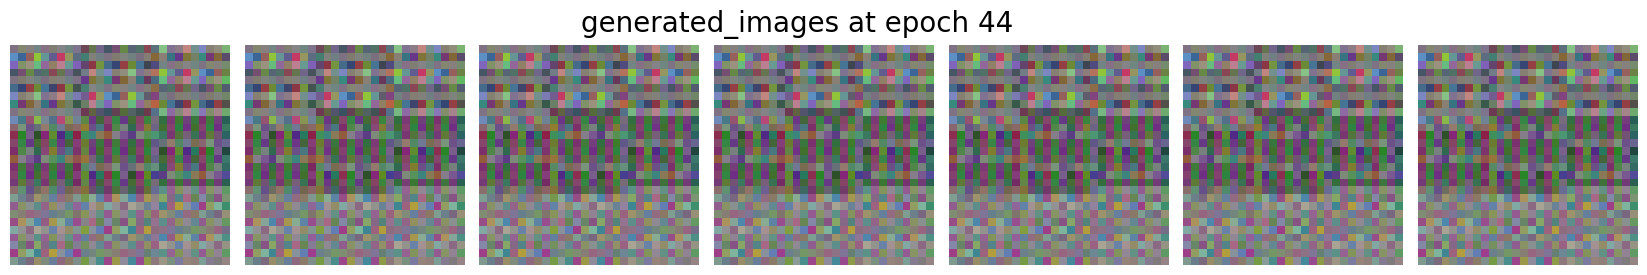

Epoch 45/100: : 100%|██████████| 155/155 [00:28<00:00,  5.52it/s, generator_loss=5.49, discriminator_loss=0.00889, D(x)=0.996, D(G(z1))=0.00487, D(G(z2))=0.00476]


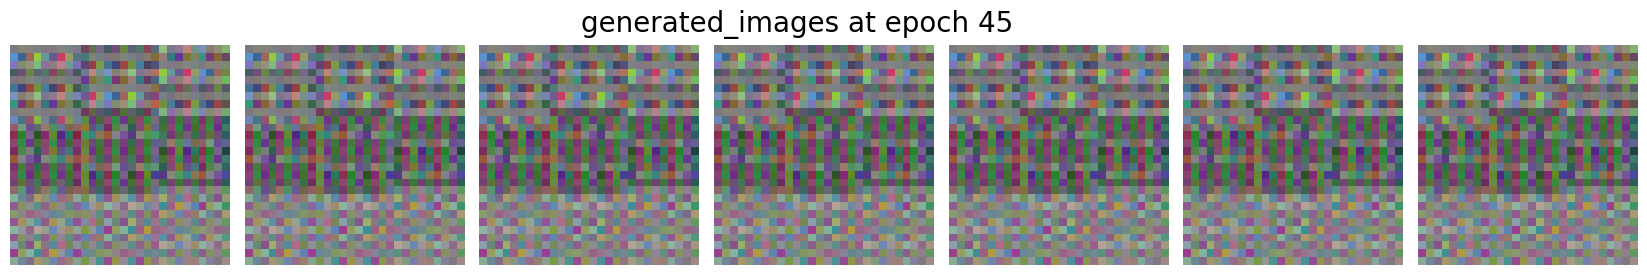

Epoch 46/100: : 100%|██████████| 155/155 [00:28<00:00,  5.48it/s, generator_loss=5.36, discriminator_loss=0.00907, D(x)=0.996, D(G(z1))=0.00538, D(G(z2))=0.00508]


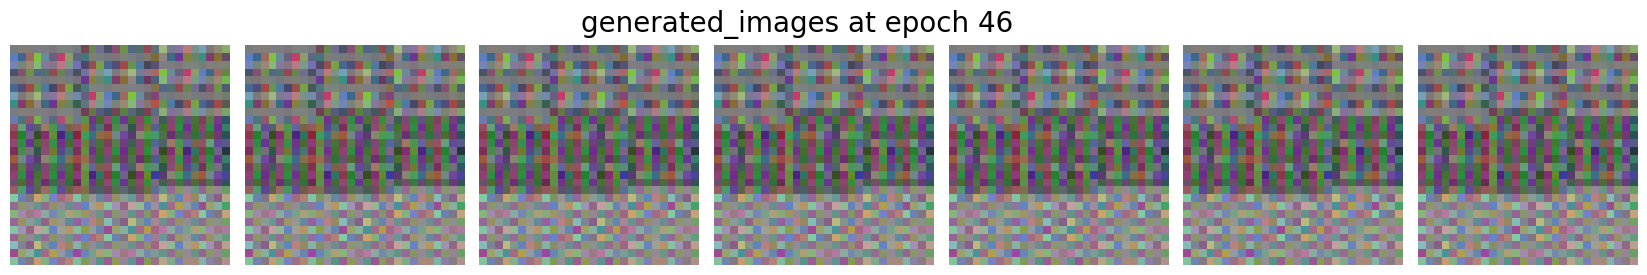

Epoch 47/100: : 100%|██████████| 155/155 [00:28<00:00,  5.49it/s, generator_loss=5.39, discriminator_loss=0.00778, D(x)=0.997, D(G(z1))=0.00465, D(G(z2))=0.00461]


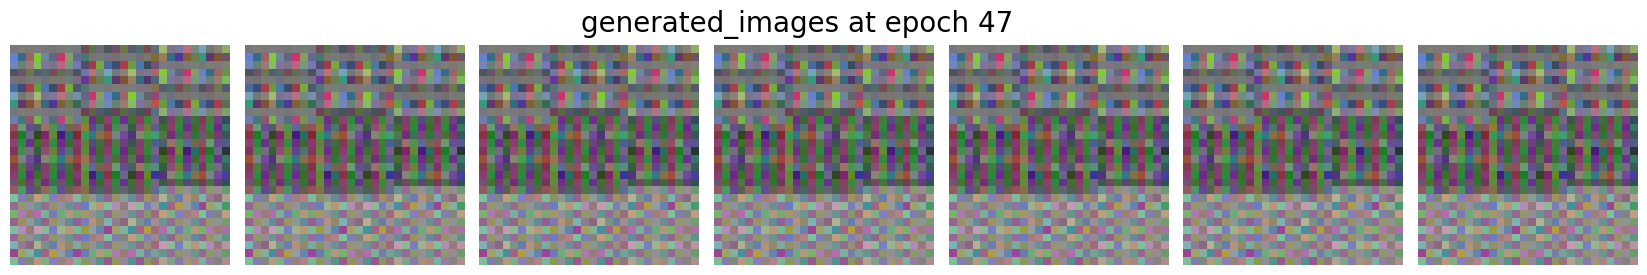

Epoch 48/100: : 100%|██████████| 155/155 [00:28<00:00,  5.47it/s, generator_loss=5.51, discriminator_loss=0.00735, D(x)=0.997, D(G(z1))=0.00438, D(G(z2))=0.00414]


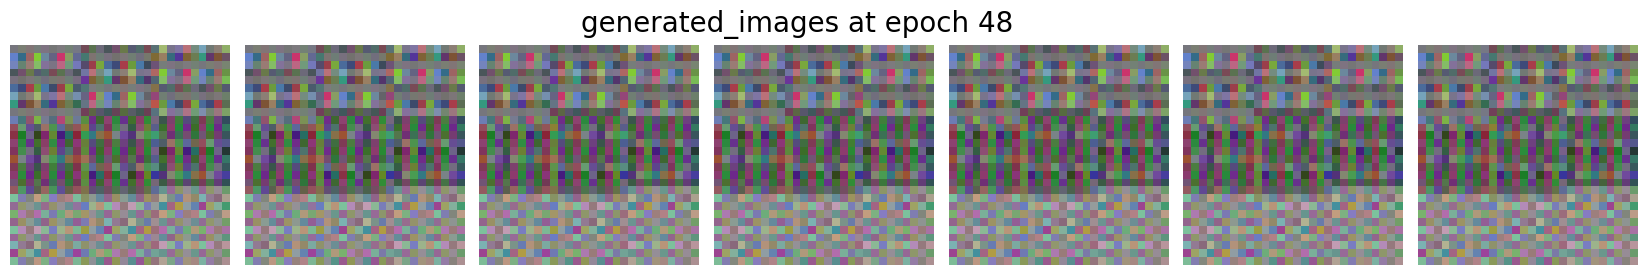

Epoch 49/100: : 100%|██████████| 155/155 [00:28<00:00,  5.45it/s, generator_loss=5.74, discriminator_loss=0.00567, D(x)=0.998, D(G(z1))=0.00331, D(G(z2))=0.00329]


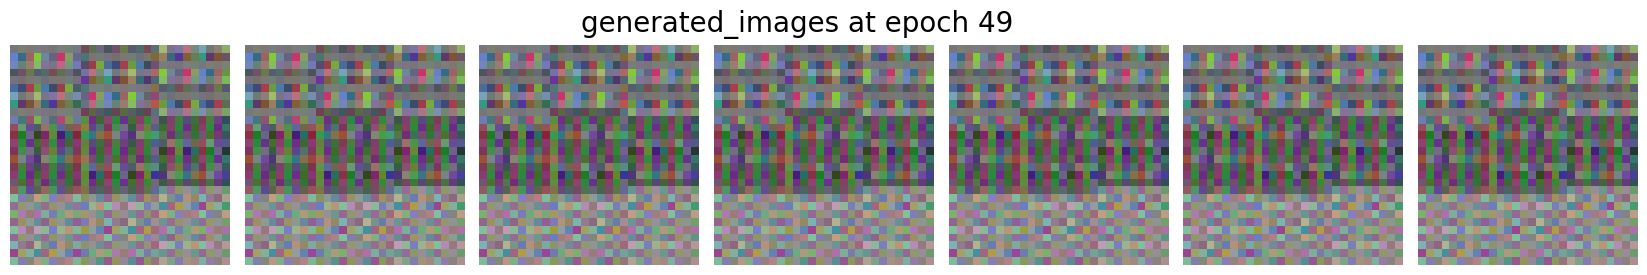

Epoch 50/100: : 100%|██████████| 155/155 [00:29<00:00,  5.22it/s, generator_loss=5.95, discriminator_loss=0.00465, D(x)=0.998, D(G(z1))=0.00274, D(G(z2))=0.00266]


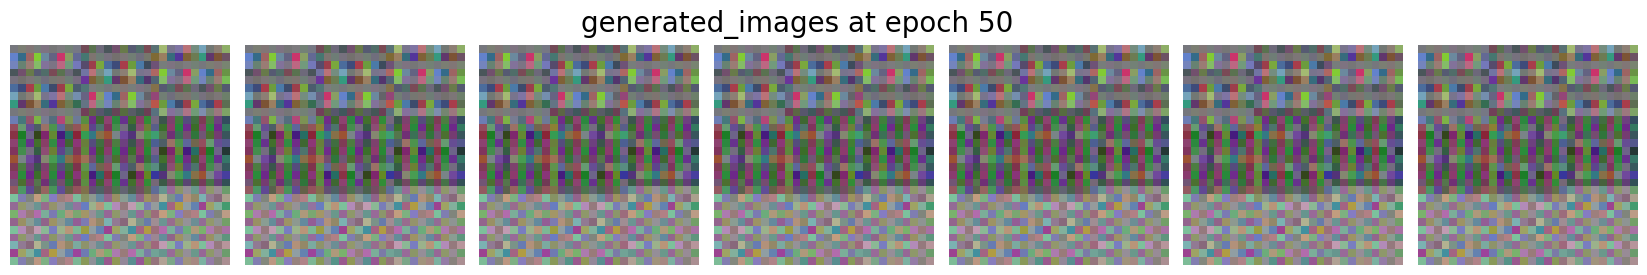

Epoch 51/100: : 100%|██████████| 155/155 [00:28<00:00,  5.47it/s, generator_loss=6.01, discriminator_loss=0.00416, D(x)=0.998, D(G(z1))=0.00248, D(G(z2))=0.00247]


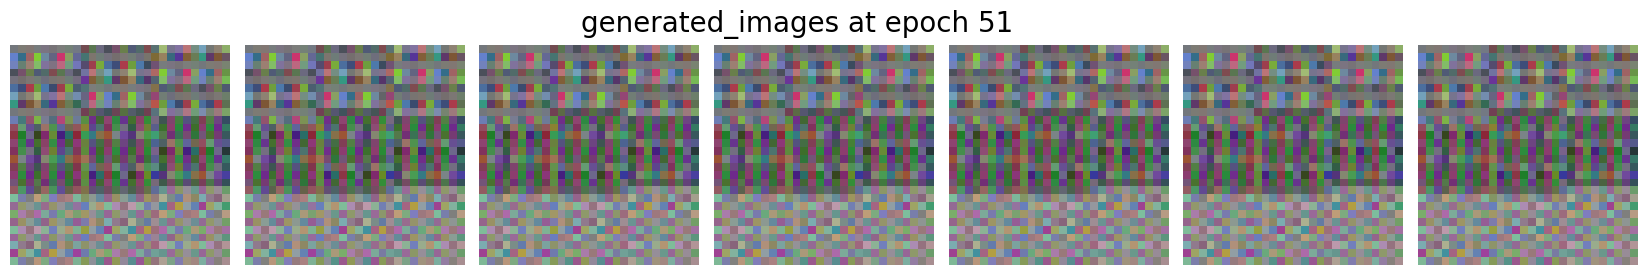

Epoch 52/100: : 100%|██████████| 155/155 [00:28<00:00,  5.42it/s, generator_loss=6.5, discriminator_loss=0.00326, D(x)=0.999, D(G(z1))=0.00183, D(G(z2))=0.00178]


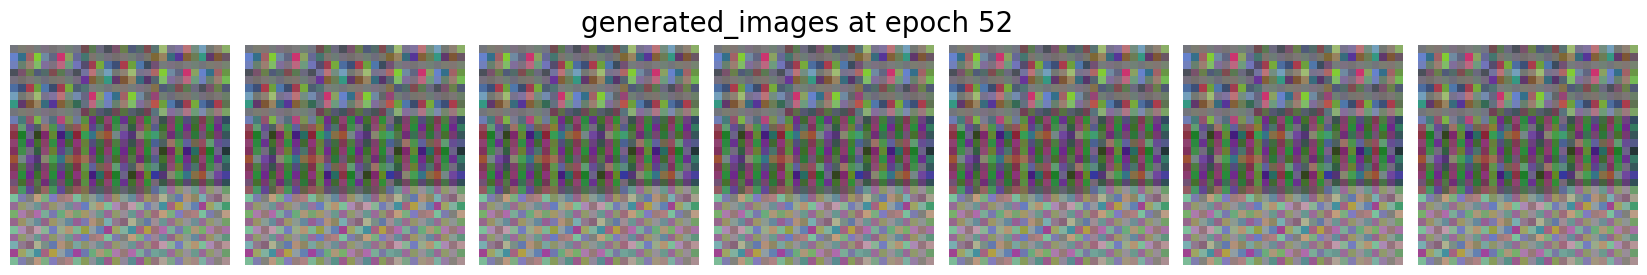

Epoch 53/100: : 100%|██████████| 155/155 [00:28<00:00,  5.45it/s, generator_loss=6.34, discriminator_loss=0.00313, D(x)=0.999, D(G(z1))=0.00189, D(G(z2))=0.00187]


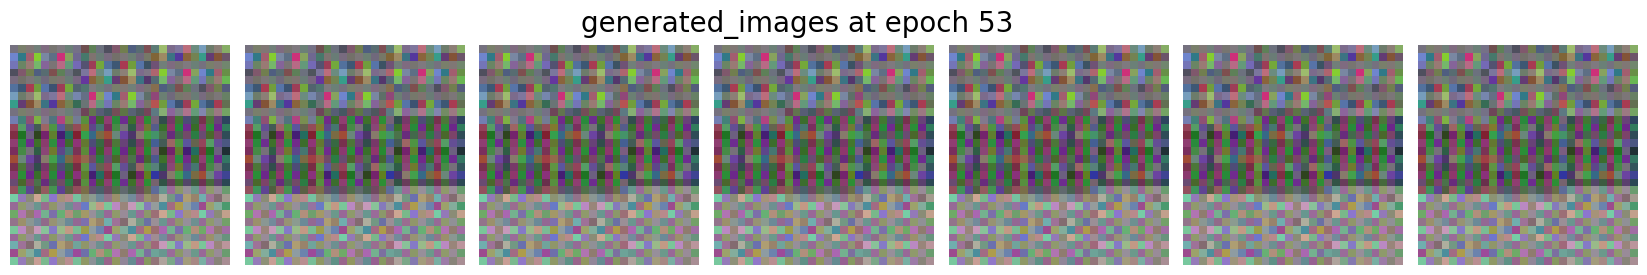

Epoch 54/100: : 100%|██████████| 155/155 [00:28<00:00,  5.47it/s, generator_loss=6.57, discriminator_loss=0.00268, D(x)=0.999, D(G(z1))=0.00159, D(G(z2))=0.00156]


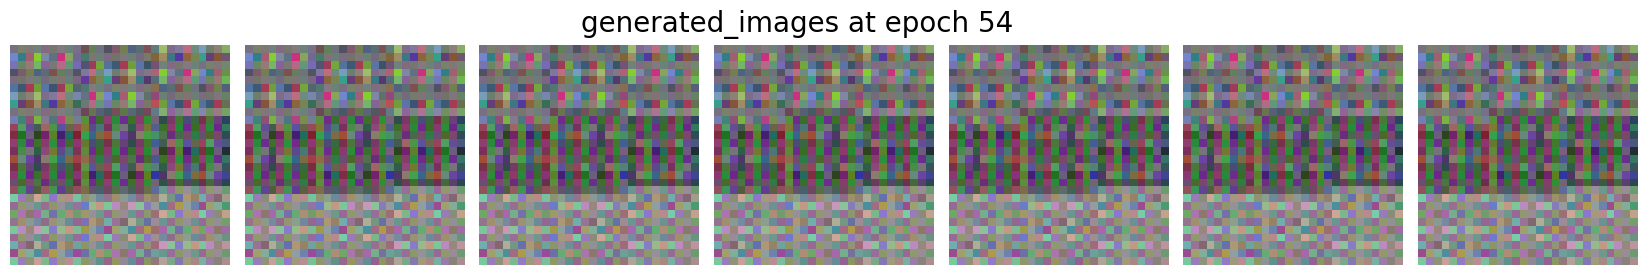

Epoch 55/100: : 100%|██████████| 155/155 [00:28<00:00,  5.49it/s, generator_loss=6.4, discriminator_loss=0.00274, D(x)=0.999, D(G(z1))=0.00174, D(G(z2))=0.00173]


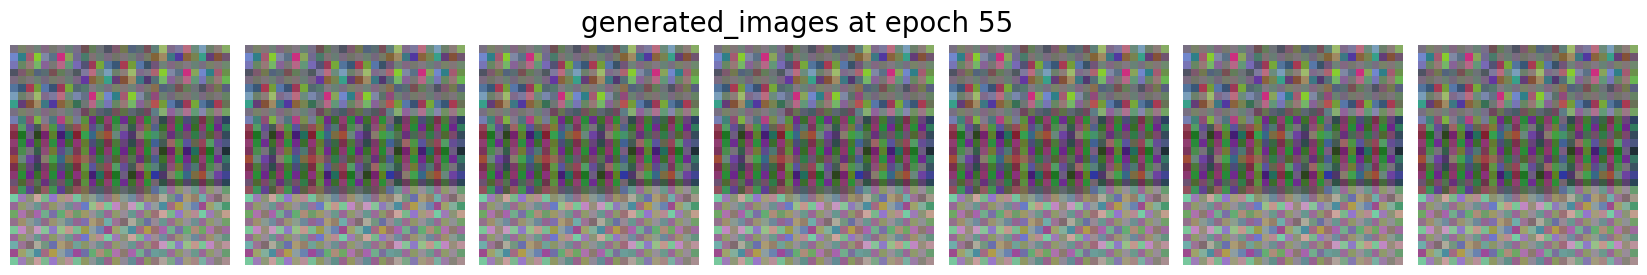

Epoch 56/100: : 100%|██████████| 155/155 [00:28<00:00,  5.47it/s, generator_loss=6.5, discriminator_loss=0.00244, D(x)=0.999, D(G(z1))=0.00155, D(G(z2))=0.00153]


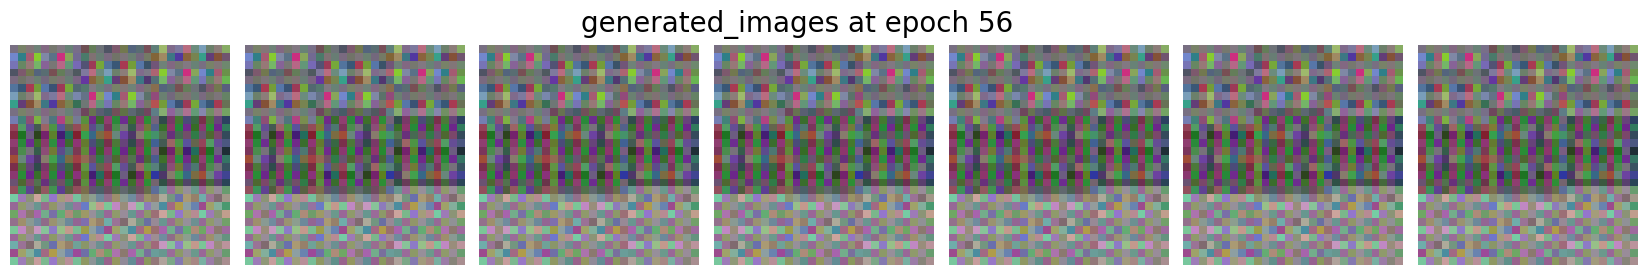

Epoch 57/100: : 100%|██████████| 155/155 [00:28<00:00,  5.45it/s, generator_loss=6.74, discriminator_loss=0.00201, D(x)=0.999, D(G(z1))=0.00122, D(G(z2))=0.00121]


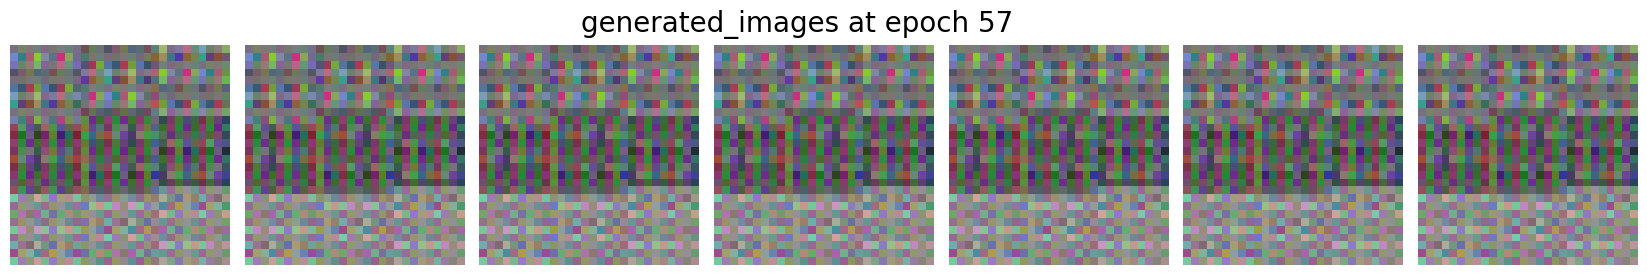

Epoch 58/100: : 100%|██████████| 155/155 [00:29<00:00,  5.26it/s, generator_loss=6.79, discriminator_loss=0.00187, D(x)=0.999, D(G(z1))=0.00116, D(G(z2))=0.00115]


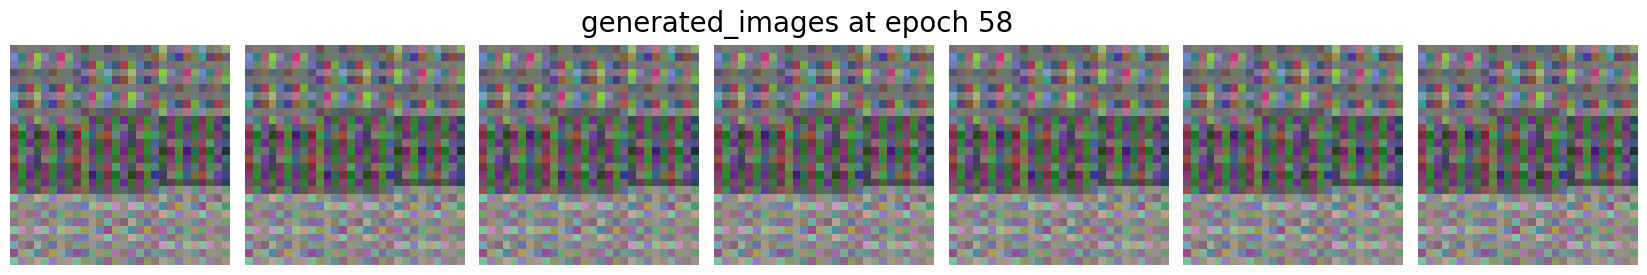

Epoch 59/100: : 100%|██████████| 155/155 [00:28<00:00,  5.47it/s, generator_loss=6.9, discriminator_loss=0.00167, D(x)=0.999, D(G(z1))=0.00103, D(G(z2))=0.00102]


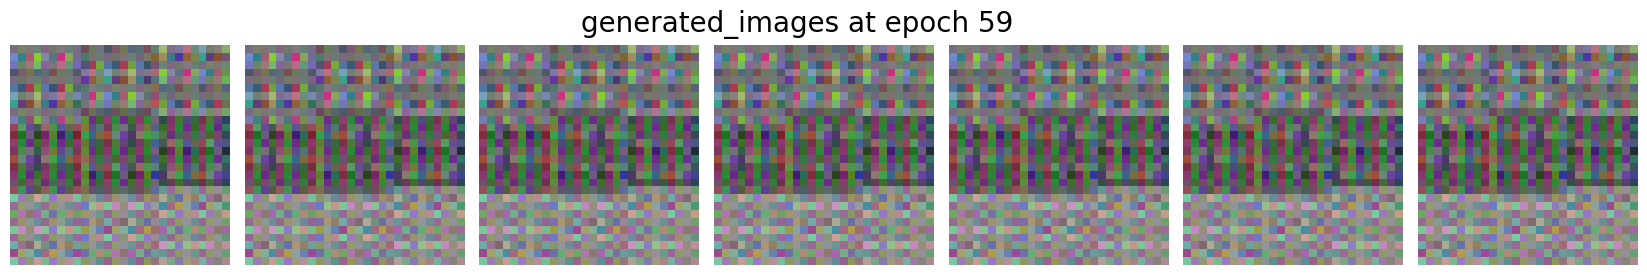

Epoch 60/100: : 100%|██████████| 155/155 [00:28<00:00,  5.53it/s, generator_loss=7.02, discriminator_loss=0.00153, D(x)=0.999, D(G(z1))=0.00092, D(G(z2))=0.000911]


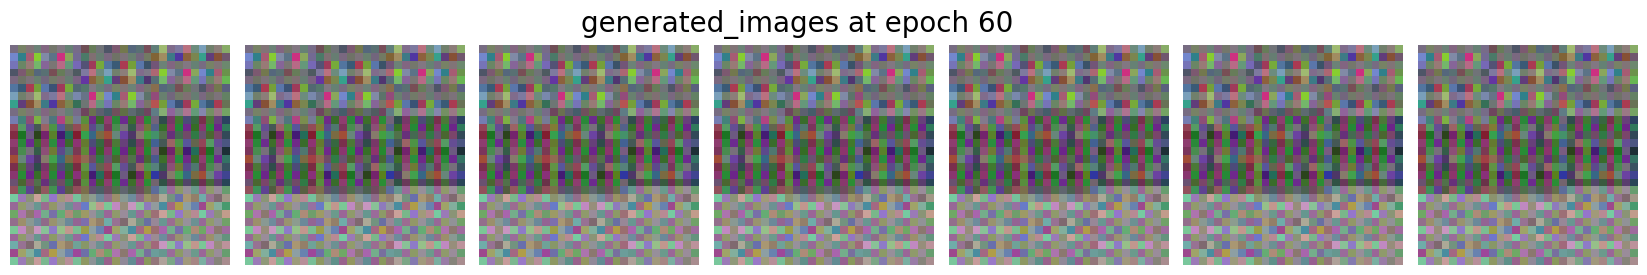

Epoch 61/100: : 100%|██████████| 155/155 [00:28<00:00,  5.45it/s, generator_loss=7.07, discriminator_loss=0.00141, D(x)=0.999, D(G(z1))=0.000869, D(G(z2))=0.000863]


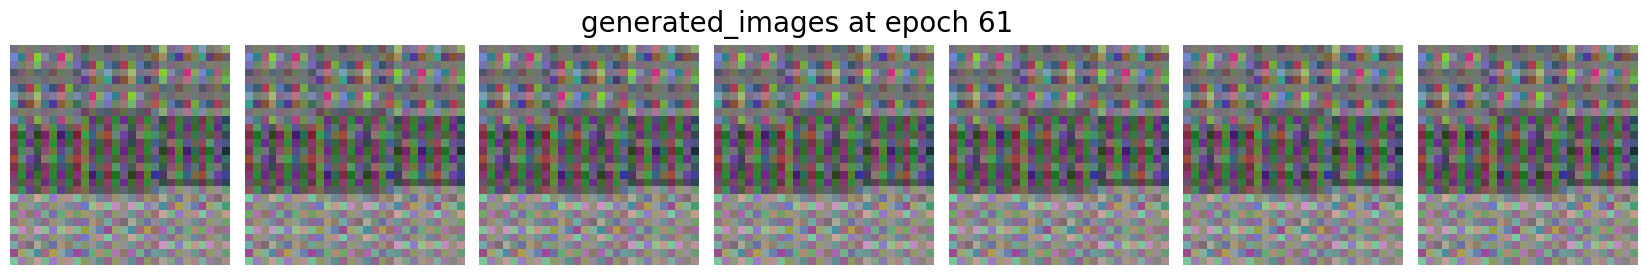

Epoch 62/100: : 100%|██████████| 155/155 [00:29<00:00,  5.26it/s, generator_loss=7.21, discriminator_loss=0.00124, D(x)=1, D(G(z1))=0.00076, D(G(z2))=0.000753]


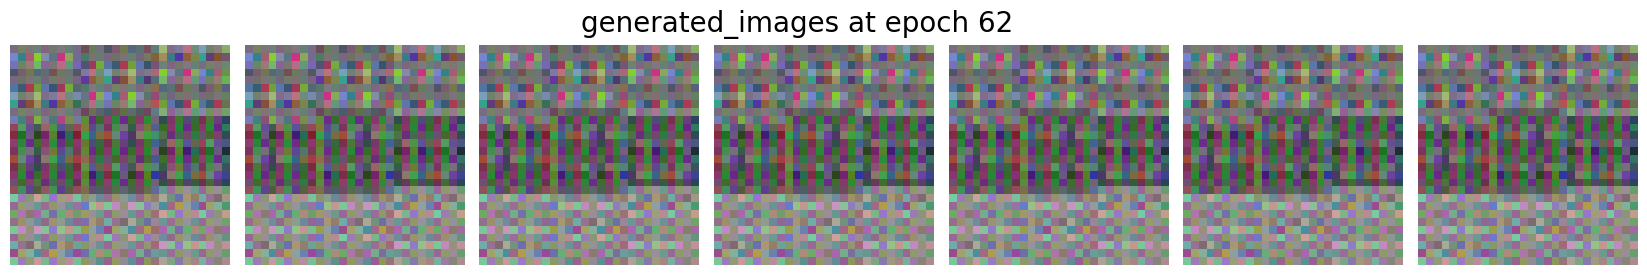

Epoch 63/100: : 100%|██████████| 155/155 [00:29<00:00,  5.23it/s, generator_loss=7.32, discriminator_loss=0.00115, D(x)=1, D(G(z1))=0.000692, D(G(z2))=0.000684]


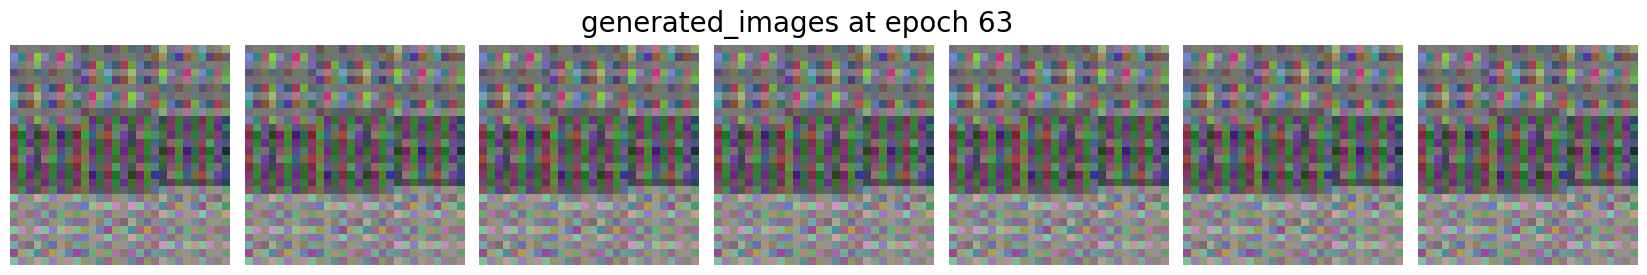

Epoch 64/100: : 100%|██████████| 155/155 [00:28<00:00,  5.43it/s, generator_loss=7.42, discriminator_loss=0.00101, D(x)=1, D(G(z1))=0.000619, D(G(z2))=0.00061]


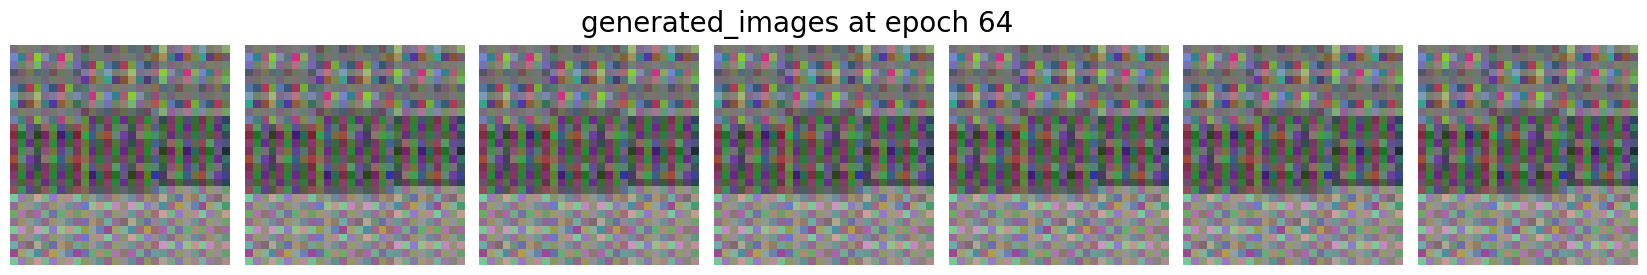

Epoch 65/100: : 100%|██████████| 155/155 [00:28<00:00,  5.37it/s, generator_loss=7.58, discriminator_loss=0.000917, D(x)=1, D(G(z1))=0.000542, D(G(z2))=0.000533]


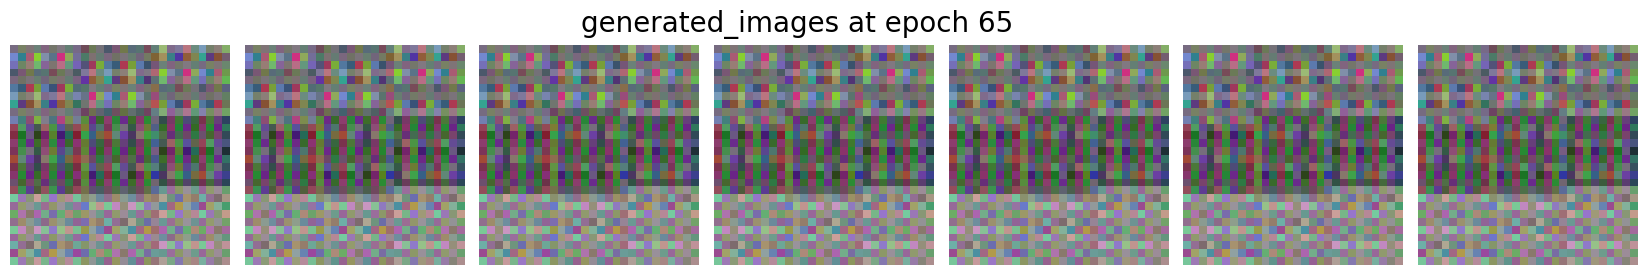

Epoch 66/100: : 100%|██████████| 155/155 [00:30<00:00,  5.16it/s, generator_loss=8.41, discriminator_loss=0.000571, D(x)=1, D(G(z1))=0.000235, D(G(z2))=0.000327]


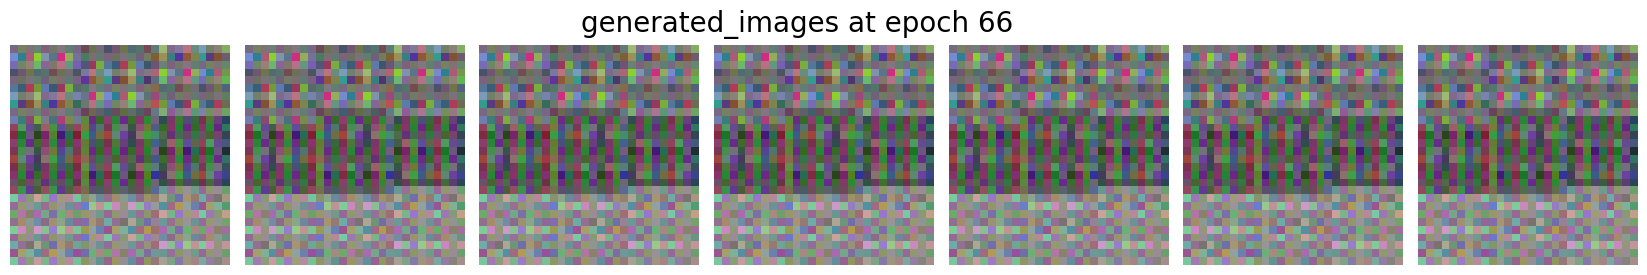

Epoch 67/100: : 100%|██████████| 155/155 [00:29<00:00,  5.21it/s, generator_loss=7.76, discriminator_loss=0.000779, D(x)=1, D(G(z1))=0.000448, D(G(z2))=0.00044]


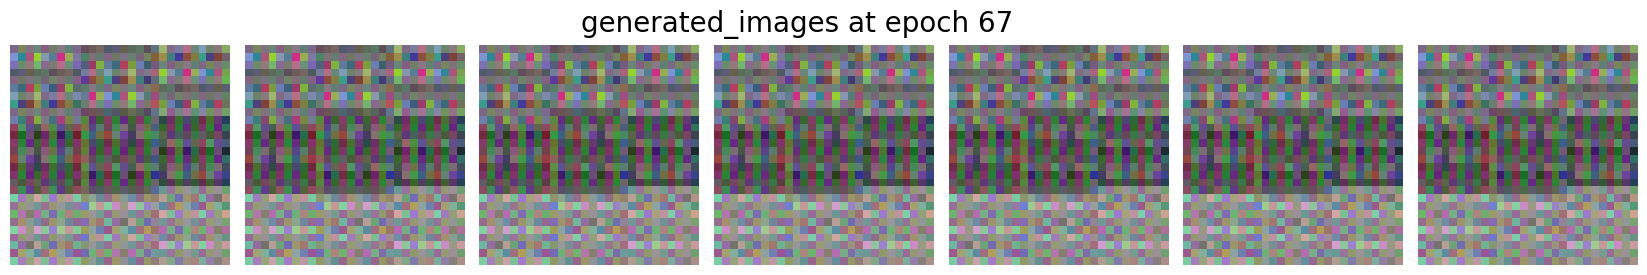

Epoch 68/100: : 100%|██████████| 155/155 [00:29<00:00,  5.26it/s, generator_loss=7.7, discriminator_loss=0.000785, D(x)=1, D(G(z1))=0.000496, D(G(z2))=0.000478]


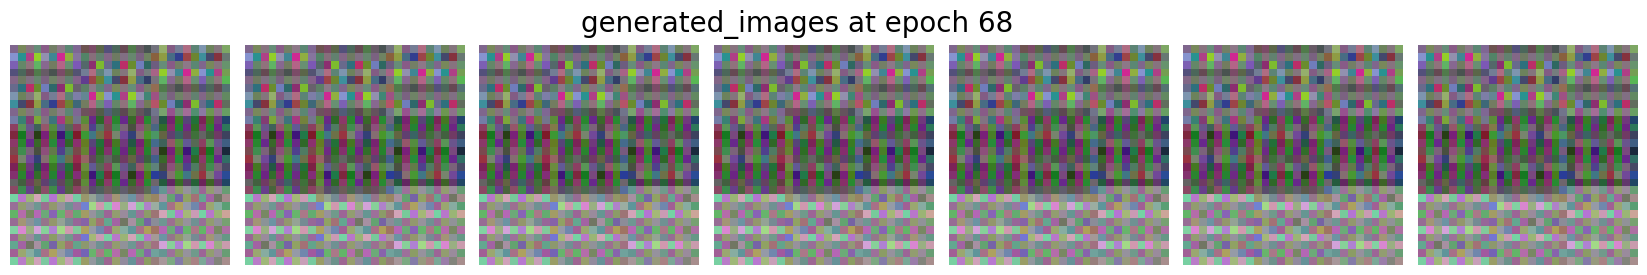

Epoch 69/100: : 100%|██████████| 155/155 [00:29<00:00,  5.25it/s, generator_loss=7.91, discriminator_loss=0.000665, D(x)=1, D(G(z1))=0.000383, D(G(z2))=0.000379]


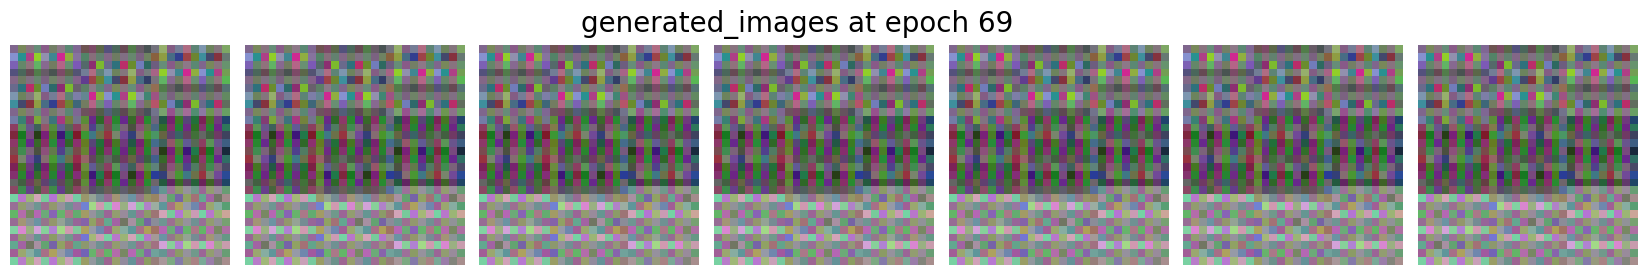

Epoch 70/100: : 100%|██████████| 155/155 [00:29<00:00,  5.20it/s, generator_loss=8.78, discriminator_loss=0.000465, D(x)=1, D(G(z1))=0.000223, D(G(z2))=0.000212]


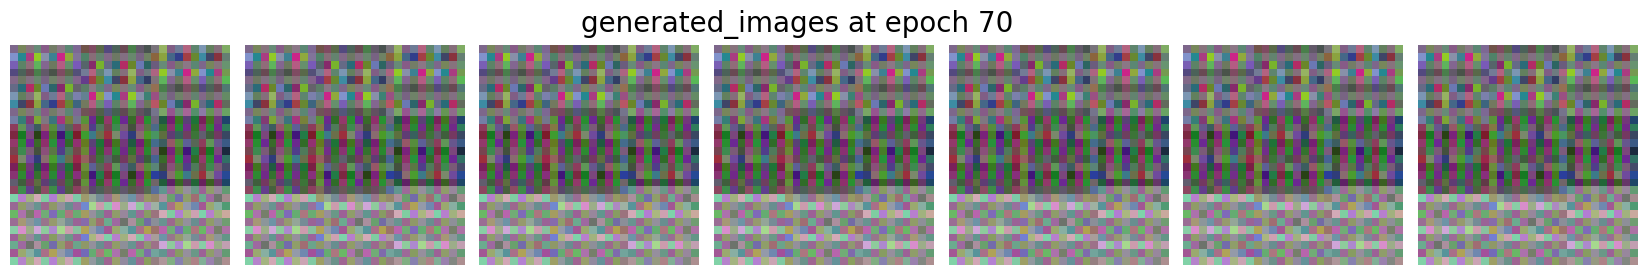

Epoch 71/100: : 100%|██████████| 155/155 [00:29<00:00,  5.17it/s, generator_loss=8.08, discriminator_loss=0.000556, D(x)=1, D(G(z1))=0.000331, D(G(z2))=0.000325]


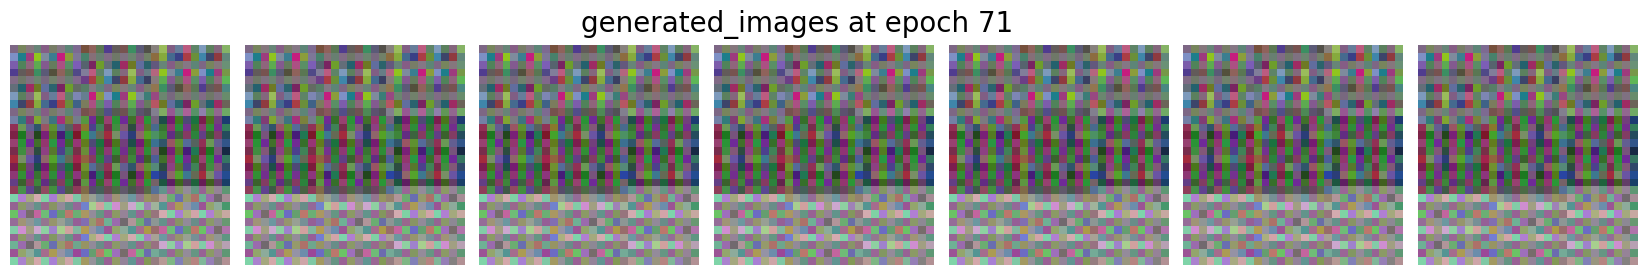

Epoch 72/100: : 100%|██████████| 155/155 [00:29<00:00,  5.30it/s, generator_loss=8.31, discriminator_loss=0.000457, D(x)=1, D(G(z1))=0.000257, D(G(z2))=0.000253]


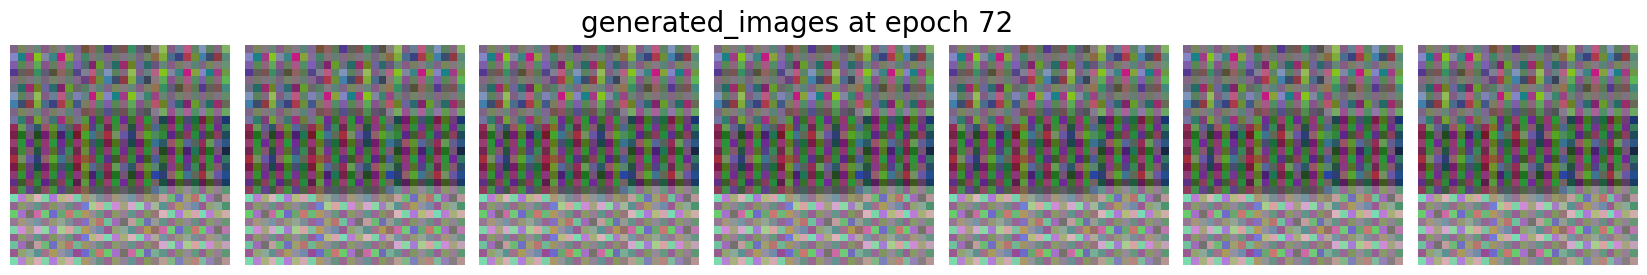

Epoch 73/100: : 100%|██████████| 155/155 [00:29<00:00,  5.26it/s, generator_loss=8.37, discriminator_loss=0.000469, D(x)=1, D(G(z1))=0.000275, D(G(z2))=0.000239]


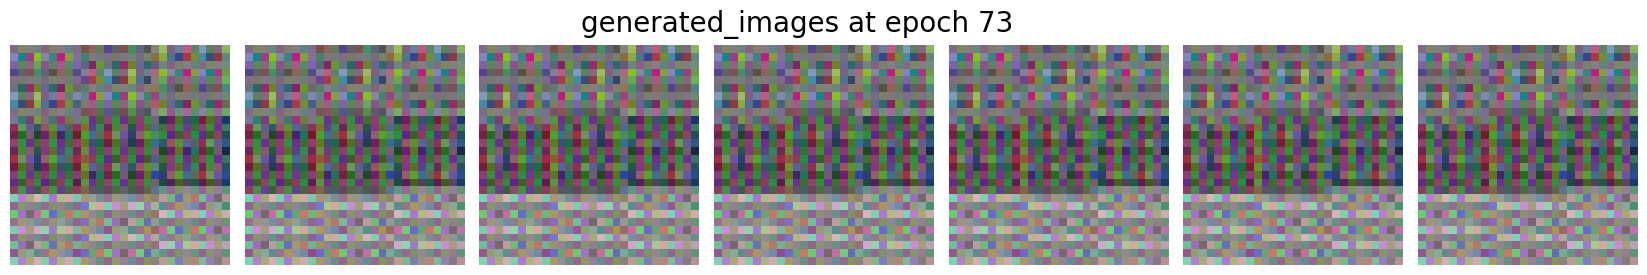

Epoch 74/100: : 100%|██████████| 155/155 [00:30<00:00,  5.13it/s, generator_loss=8.25, discriminator_loss=0.000437, D(x)=1, D(G(z1))=0.000274, D(G(z2))=0.000269]


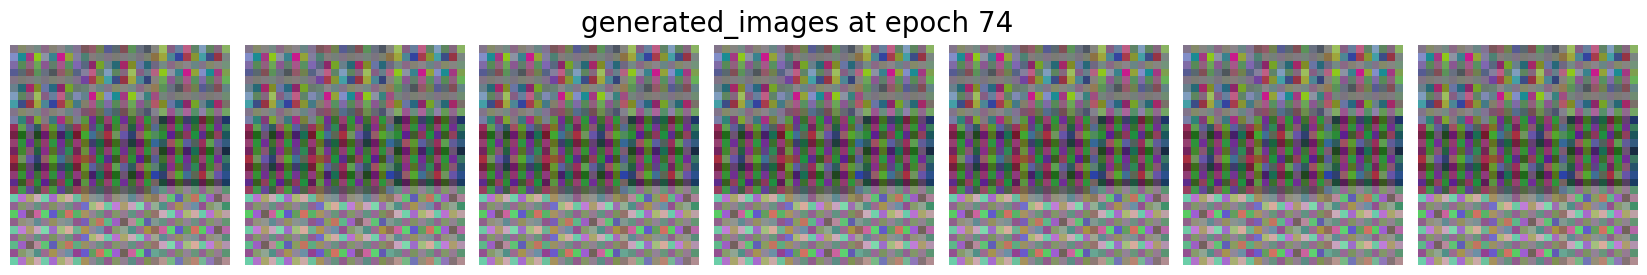

Epoch 75/100: : 100%|██████████| 155/155 [00:30<00:00,  5.16it/s, generator_loss=8.37, discriminator_loss=0.000392, D(x)=1, D(G(z1))=0.000237, D(G(z2))=0.000235]


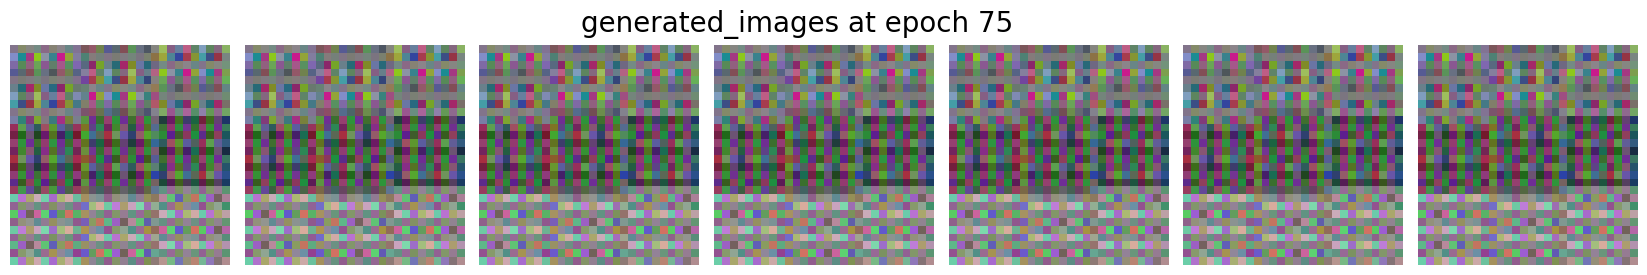

Epoch 76/100: : 100%|██████████| 155/155 [00:29<00:00,  5.19it/s, generator_loss=8.48, discriminator_loss=0.000353, D(x)=1, D(G(z1))=0.000213, D(G(z2))=0.000212]


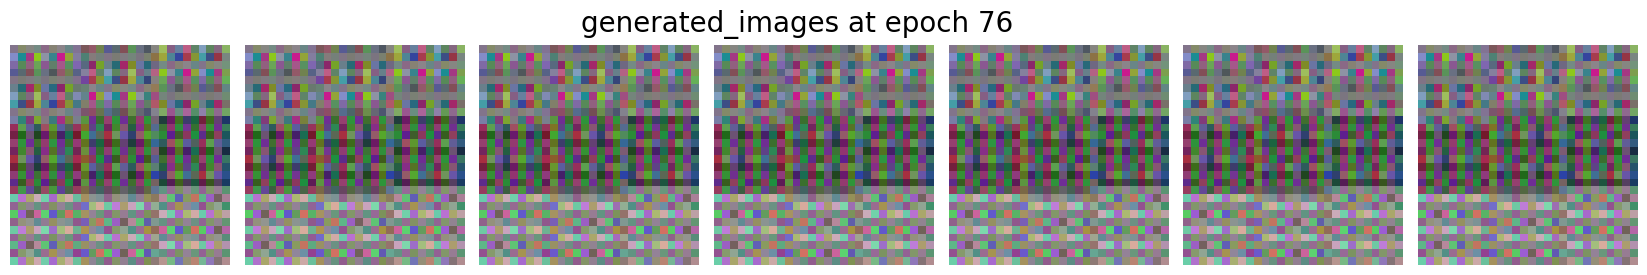

Epoch 77/100: : 100%|██████████| 155/155 [00:29<00:00,  5.19it/s, generator_loss=8.61, discriminator_loss=0.000318, D(x)=1, D(G(z1))=0.000186, D(G(z2))=0.000185]


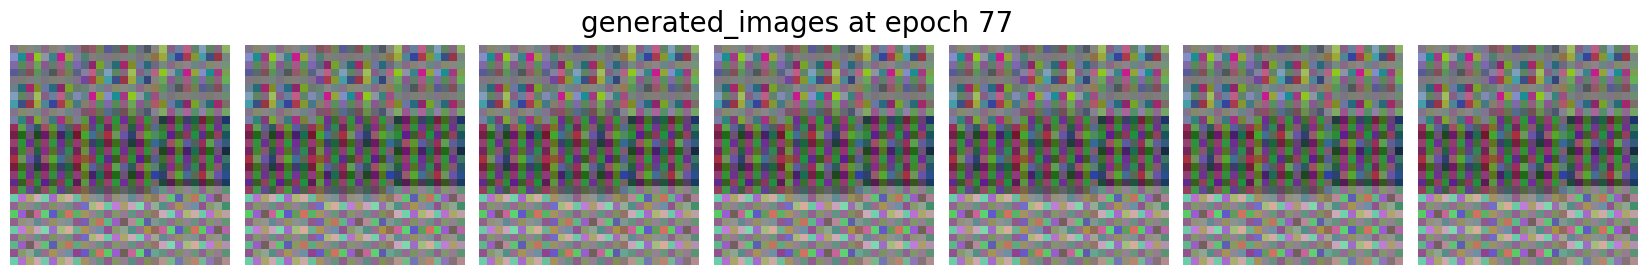

Epoch 78/100: : 100%|██████████| 155/155 [00:29<00:00,  5.25it/s, generator_loss=8.7, discriminator_loss=0.00028, D(x)=1, D(G(z1))=0.000169, D(G(z2))=0.000168]


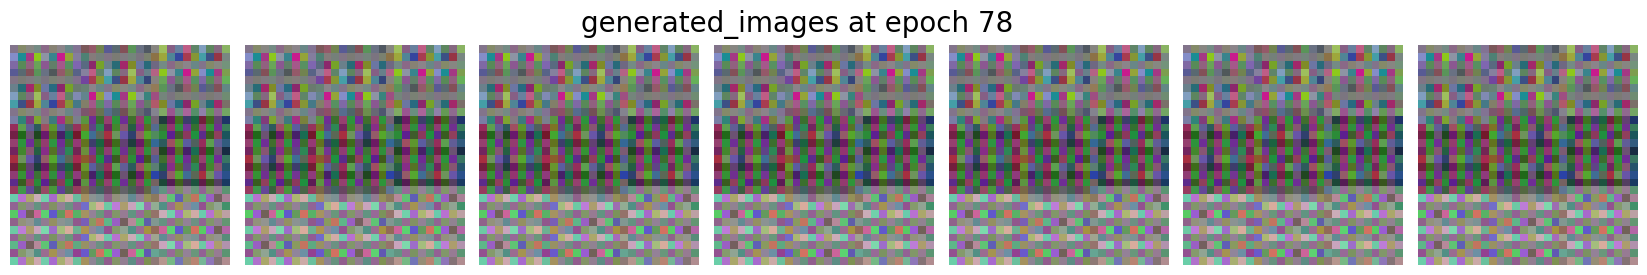

Epoch 79/100: : 100%|██████████| 155/155 [00:29<00:00,  5.22it/s, generator_loss=8.77, discriminator_loss=0.000255, D(x)=1, D(G(z1))=0.000158, D(G(z2))=0.000157]


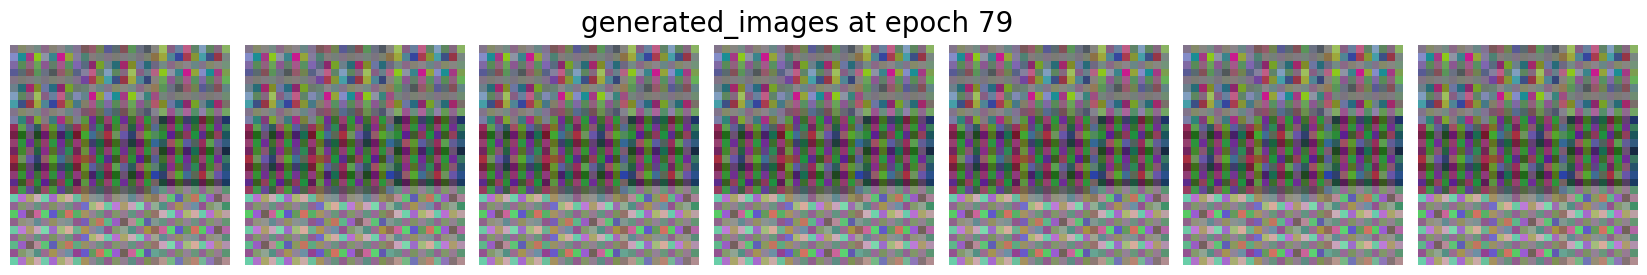

Epoch 80/100: : 100%|██████████| 155/155 [00:29<00:00,  5.26it/s, generator_loss=8.86, discriminator_loss=0.000233, D(x)=1, D(G(z1))=0.000145, D(G(z2))=0.000144]


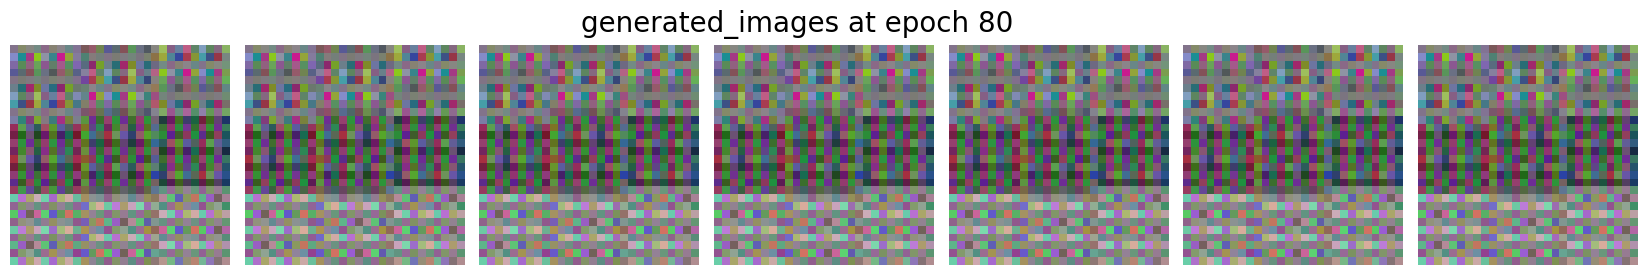

Epoch 81/100: : 100%|██████████| 155/155 [00:29<00:00,  5.22it/s, generator_loss=8.99, discriminator_loss=0.000209, D(x)=1, D(G(z1))=0.000129, D(G(z2))=0.000128]


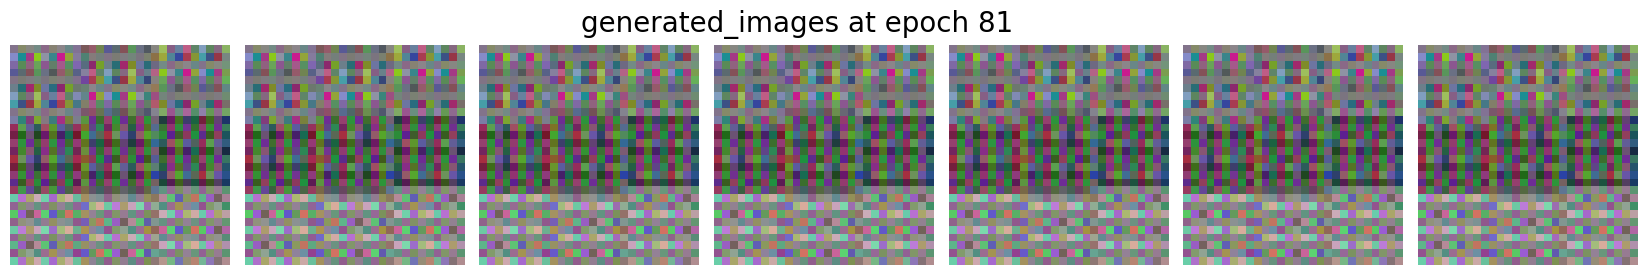

Epoch 82/100: : 100%|██████████| 155/155 [00:29<00:00,  5.27it/s, generator_loss=9.18, discriminator_loss=0.000185, D(x)=1, D(G(z1))=0.000112, D(G(z2))=0.00011]


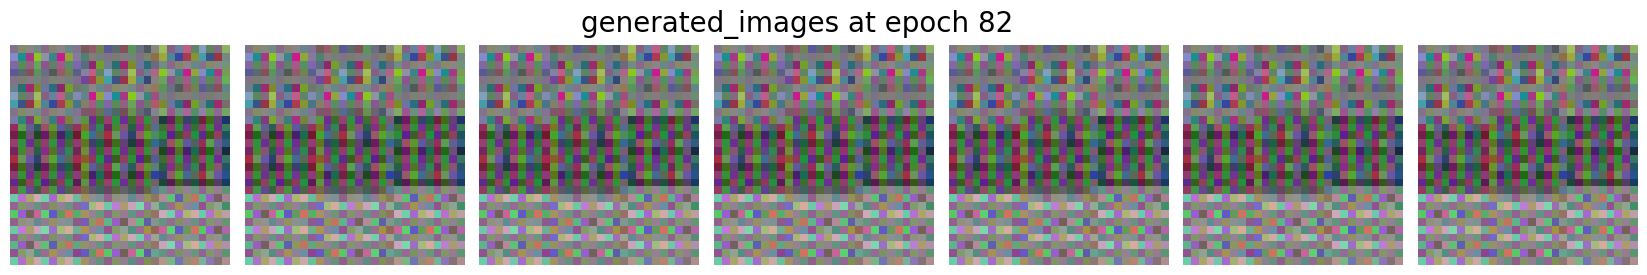

Epoch 83/100: : 100%|██████████| 155/155 [00:30<00:00,  5.10it/s, generator_loss=9.18, discriminator_loss=0.000182, D(x)=1, D(G(z1))=0.00011, D(G(z2))=0.000108]


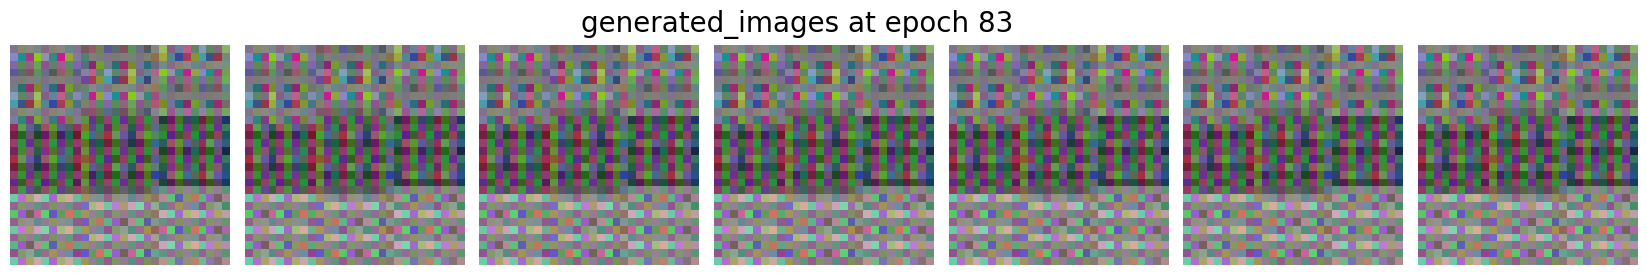

Epoch 84/100: : 100%|██████████| 155/155 [00:29<00:00,  5.17it/s, generator_loss=9.31, discriminator_loss=0.00016, D(x)=1, D(G(z1))=9.37e-5, D(G(z2))=9.22e-5]


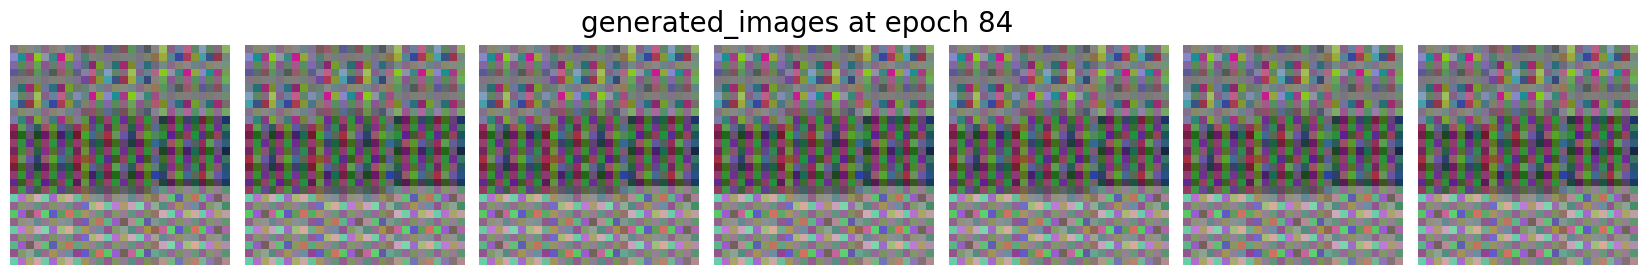

Epoch 85/100: : 100%|██████████| 155/155 [00:30<00:00,  5.09it/s, generator_loss=9.36, discriminator_loss=0.000146, D(x)=1, D(G(z1))=8.95e-5, D(G(z2))=8.72e-5]


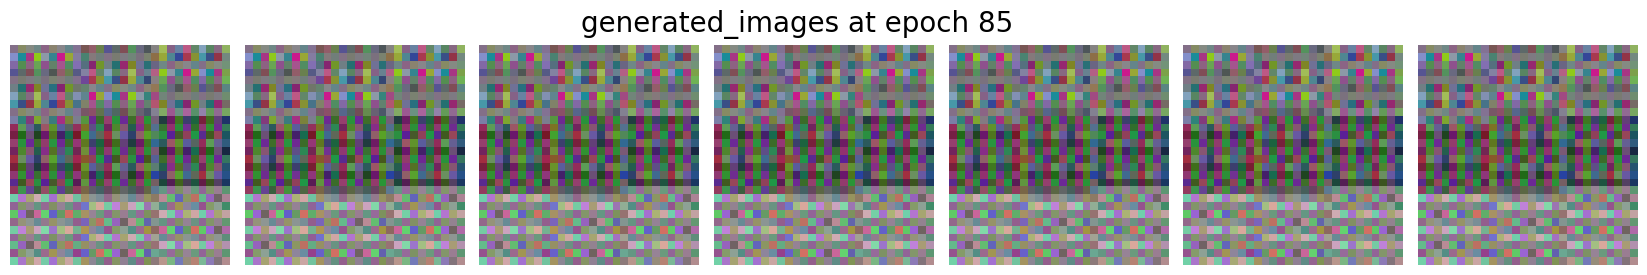

Epoch 86/100: : 100%|██████████| 155/155 [00:30<00:00,  5.14it/s, generator_loss=9.37, discriminator_loss=0.000144, D(x)=1, D(G(z1))=8.83e-5, D(G(z2))=8.71e-5]


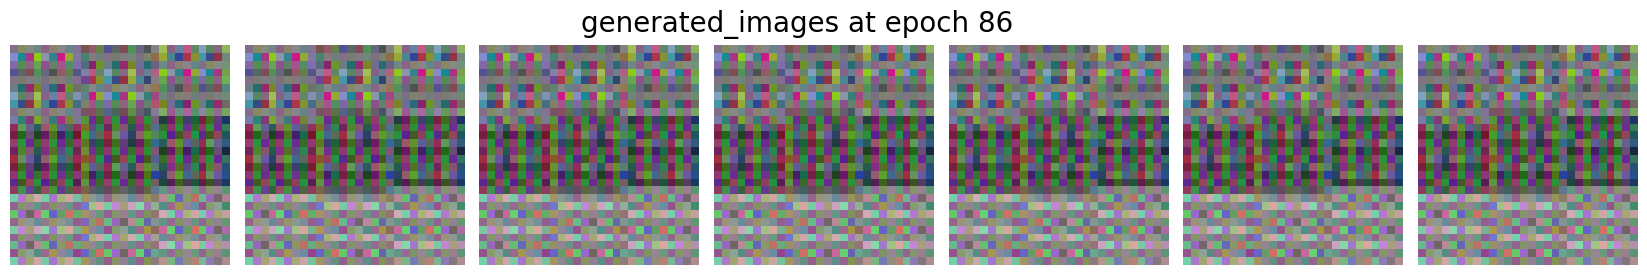

Epoch 87/100: : 100%|██████████| 155/155 [00:30<00:00,  5.13it/s, generator_loss=9.56, discriminator_loss=0.000124, D(x)=1, D(G(z1))=7.28e-5, D(G(z2))=7.16e-5]


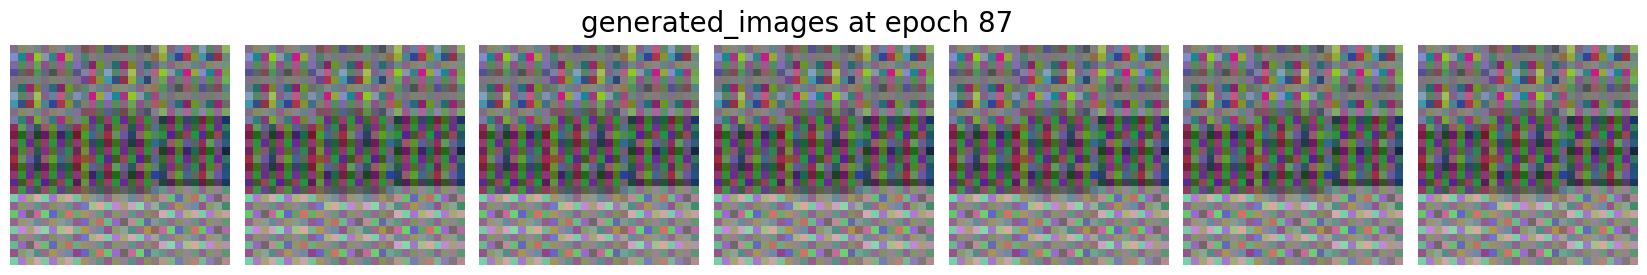

Epoch 88/100: : 100%|██████████| 155/155 [00:29<00:00,  5.19it/s, generator_loss=9.55, discriminator_loss=0.000121, D(x)=1, D(G(z1))=7.32e-5, D(G(z2))=7.24e-5]


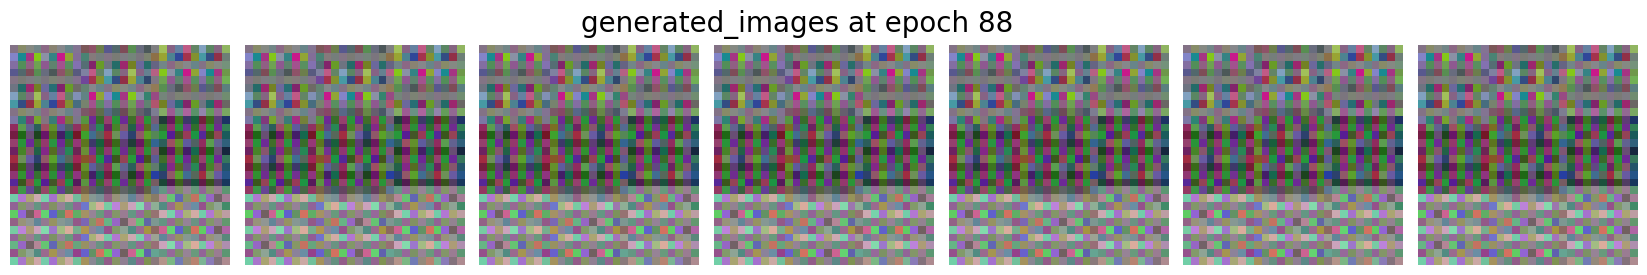

Epoch 89/100: : 100%|██████████| 155/155 [00:30<00:00,  5.10it/s, generator_loss=9.99, discriminator_loss=9.32e-5, D(x)=1, D(G(z1))=5.1e-5, D(G(z2))=4.96e-5]


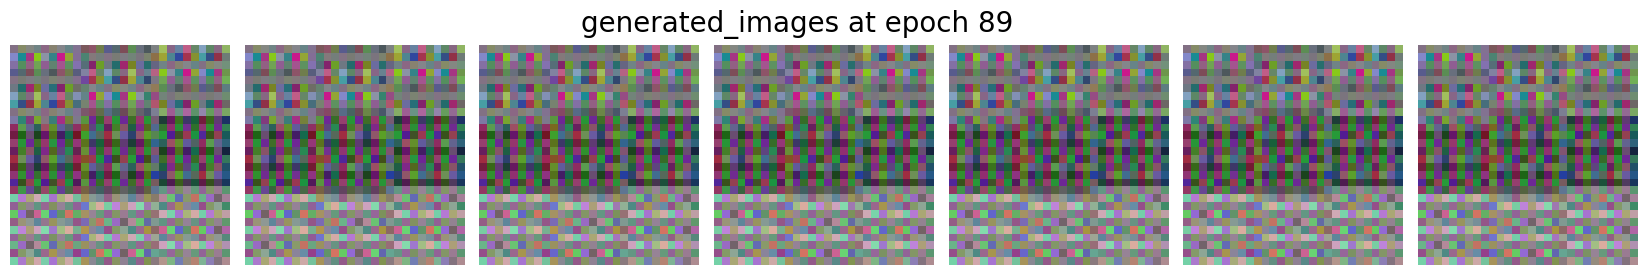

Epoch 90/100: : 100%|██████████| 155/155 [00:30<00:00,  5.09it/s, generator_loss=9.63, discriminator_loss=0.000117, D(x)=1, D(G(z1))=7.72e-5, D(G(z2))=7.37e-5]


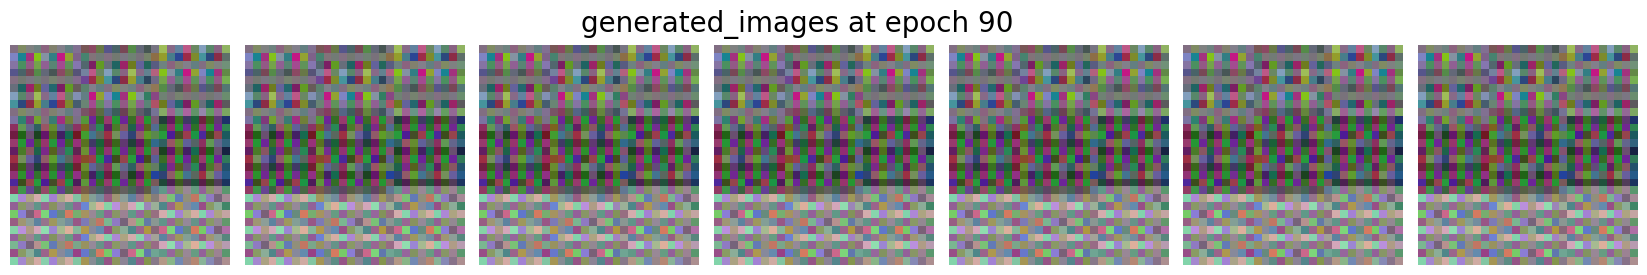

Epoch 91/100: : 100%|██████████| 155/155 [00:30<00:00,  5.02it/s, generator_loss=9.81, discriminator_loss=9.47e-5, D(x)=1, D(G(z1))=5.72e-5, D(G(z2))=5.61e-5]


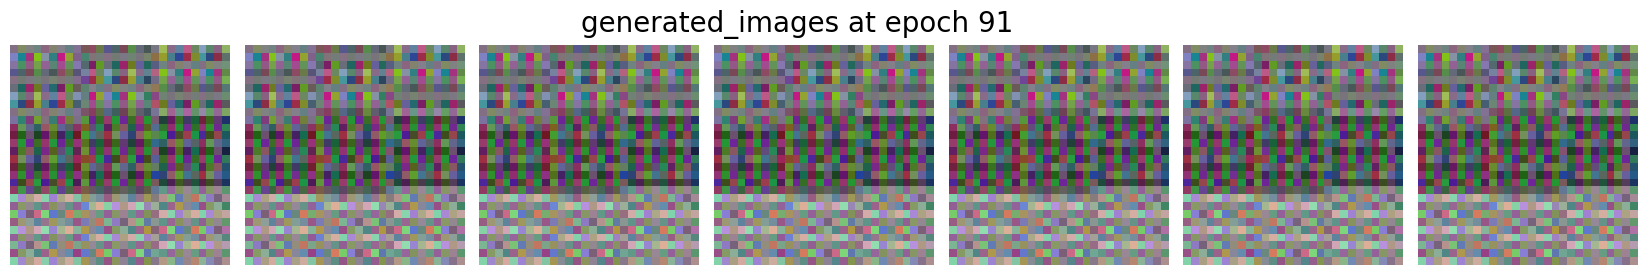

Epoch 92/100: : 100%|██████████| 155/155 [00:30<00:00,  5.01it/s, generator_loss=9.86, discriminator_loss=9.57e-5, D(x)=1, D(G(z1))=5.51e-5, D(G(z2))=5.42e-5]


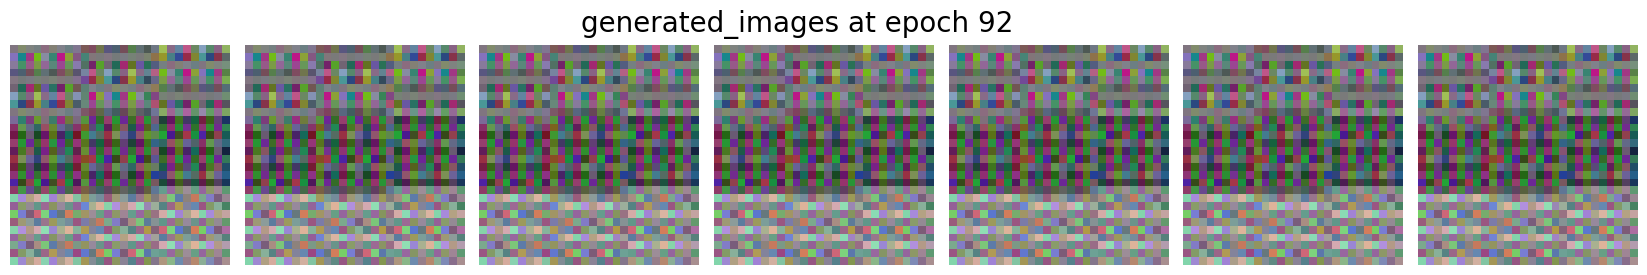

Epoch 93/100: : 100%|██████████| 155/155 [00:30<00:00,  5.12it/s, generator_loss=10, discriminator_loss=7.87e-5, D(x)=1, D(G(z1))=4.63e-5, D(G(z2))=4.58e-5]


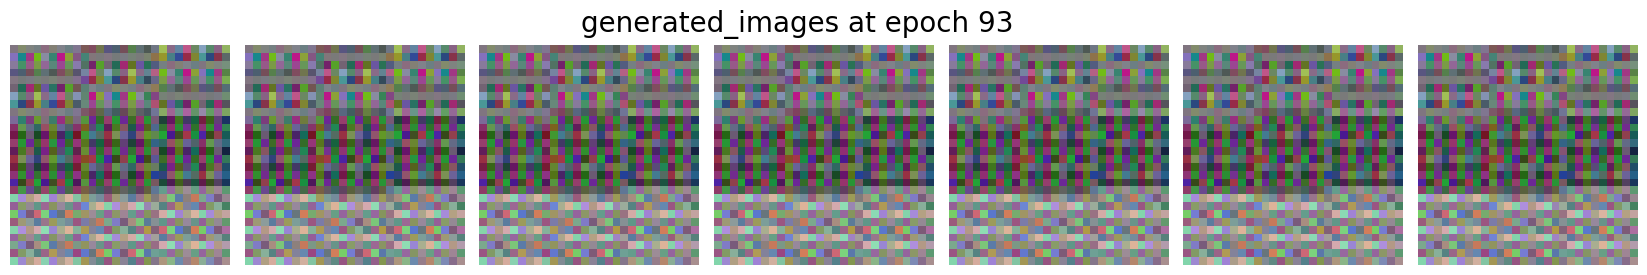

Epoch 94/100: : 100%|██████████| 155/155 [00:30<00:00,  5.09it/s, generator_loss=10.3, discriminator_loss=6.93e-5, D(x)=1, D(G(z1))=4.14e-5, D(G(z2))=3.79e-5]


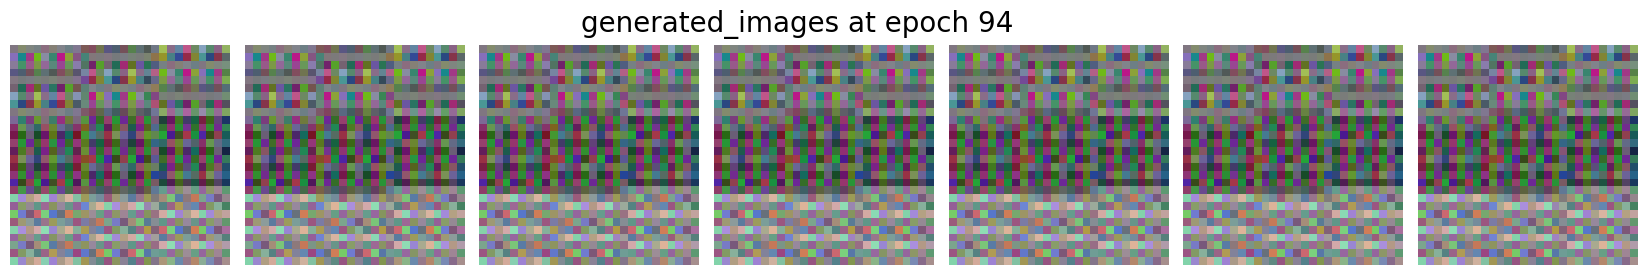

Epoch 95/100: : 100%|██████████| 155/155 [00:31<00:00,  4.96it/s, generator_loss=10.1, discriminator_loss=6.58e-5, D(x)=1, D(G(z1))=4.11e-5, D(G(z2))=4.05e-5]


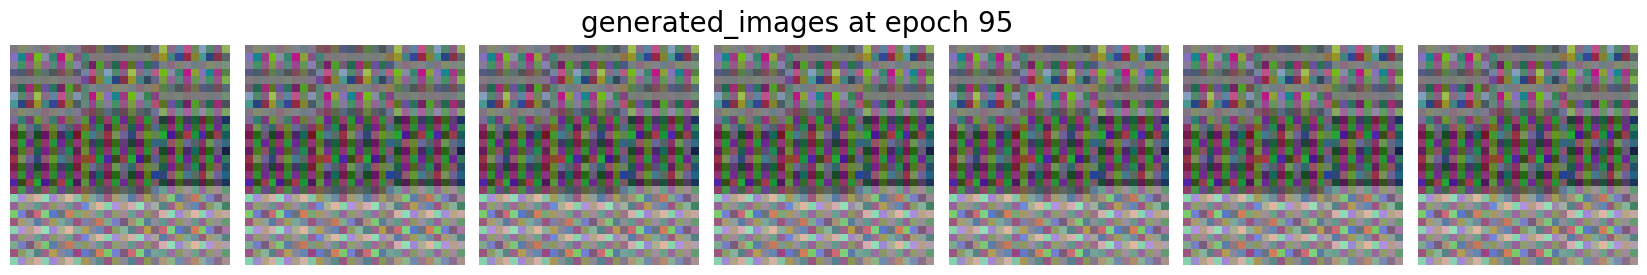

Epoch 96/100: : 100%|██████████| 155/155 [00:30<00:00,  5.01it/s, generator_loss=10.3, discriminator_loss=6e-5, D(x)=1, D(G(z1))=3.75e-5, D(G(z2))=3.7e-5]


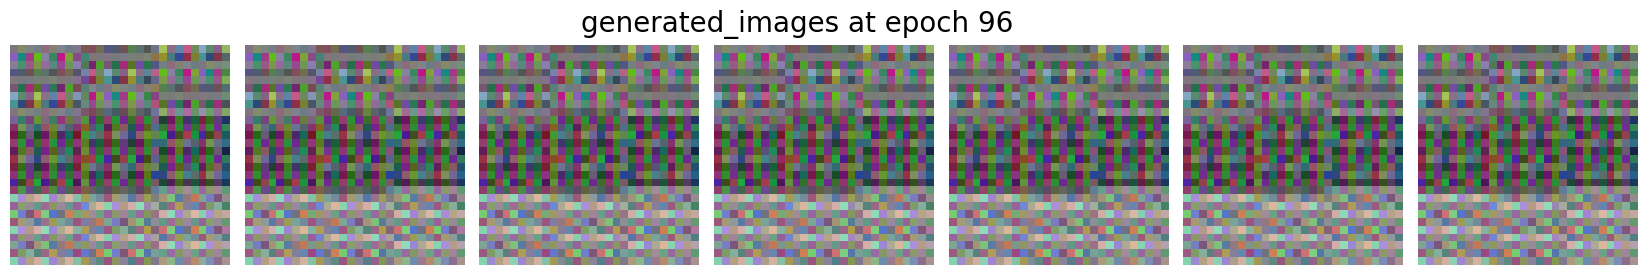

Epoch 97/100: : 100%|██████████| 155/155 [00:30<00:00,  5.11it/s, generator_loss=10.4, discriminator_loss=5.34e-5, D(x)=1, D(G(z1))=3.24e-5, D(G(z2))=3.2e-5]


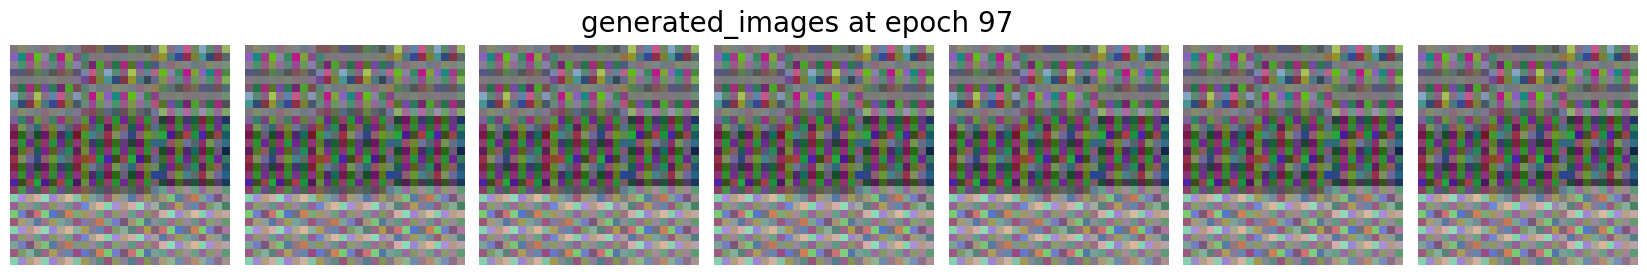

Epoch 98/100: : 100%|██████████| 155/155 [00:31<00:00,  4.90it/s, generator_loss=10.5, discriminator_loss=4.93e-5, D(x)=1, D(G(z1))=3.03e-5, D(G(z2))=2.98e-5]


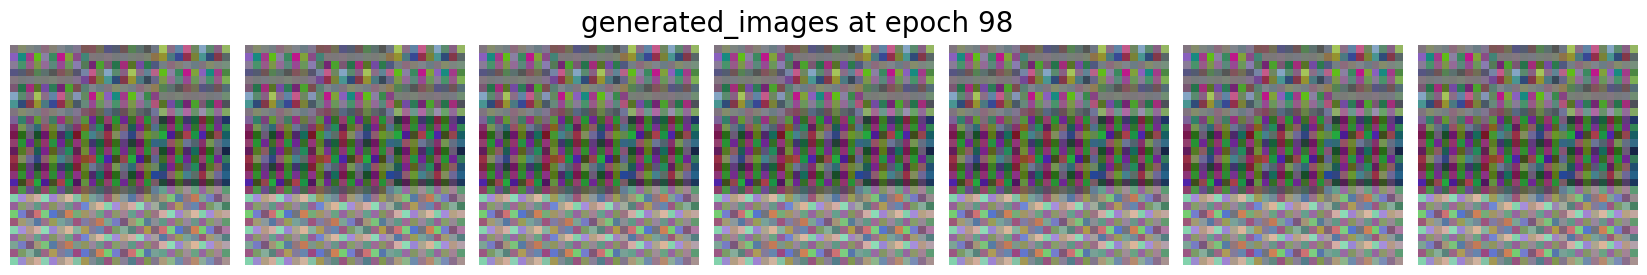

Epoch 99/100: : 100%|██████████| 155/155 [00:30<00:00,  5.06it/s, generator_loss=10.6, discriminator_loss=4.61e-5, D(x)=1, D(G(z1))=2.84e-5, D(G(z2))=2.73e-5]


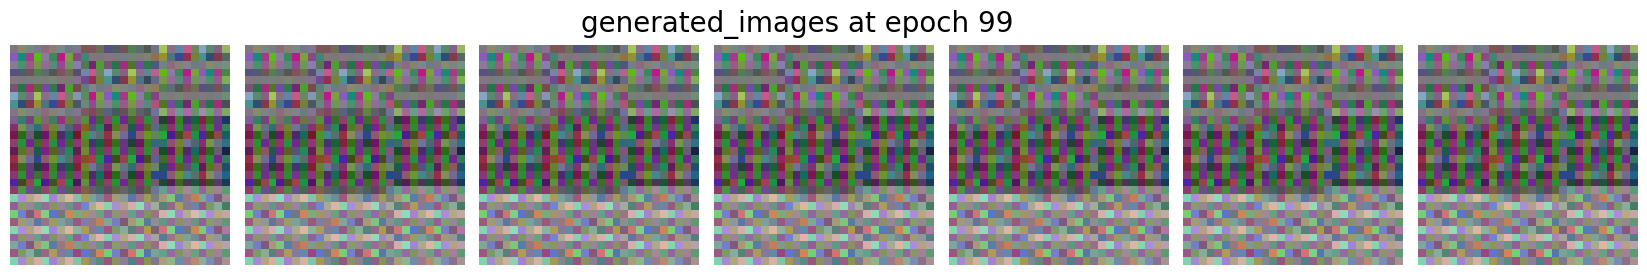

Epoch 100/100: : 100%|██████████| 155/155 [00:30<00:00,  5.11it/s, generator_loss=10.6, discriminator_loss=4.18e-5, D(x)=1, D(G(z1))=2.54e-5, D(G(z2))=2.48e-5]


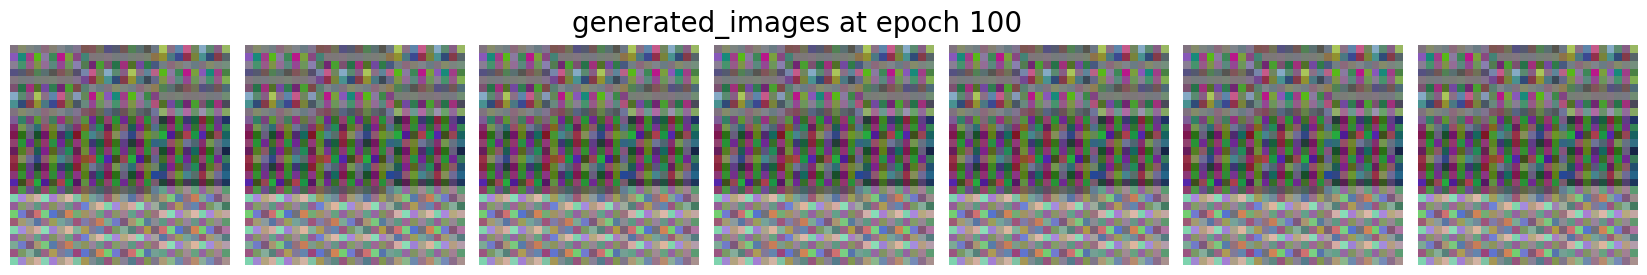

In [15]:
sample_noise = torch.randn(7, Z).to(device)

disc_loss = []
gen_loss = []
# Training loop
for i in range(1,EPOCHS+1):
  pbar = tqdm(train_loader)
  G_total_loss = 0
  D_total_loss = 0
  for b, data in enumerate(pbar):
    # Every data instance is an input + label pair. We don't need the label
    inputs = data
    inputs = inputs.to(device)
    inputs = (inputs - 0.5) * 2 # setting data range to [-1,1]

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################

    ## Train with all-real batch
    discriminator.zero_grad()
    # Set up labels
    label = torch.full((inputs.shape[0],1), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = discriminator(inputs)
    # Calculate loss on all-real batch
    errD_real = loss_fn(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(inputs.shape[0], Z, device=device)
    # Generate fake image batch with G
    fake = generator(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = discriminator(fake.detach())
    # Calculate D's loss on the all-fake batch
    errD_fake = loss_fn(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizer_disc.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    generator.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = discriminator(fake)
    # Calculate G's loss based on this output
    errG = loss_fn(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizer_gen.step()

    pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    pbar.set_postfix({"generator_loss": errG.item(), "discriminator_loss": errD.item(), "D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2})
    G_total_loss += errG.item()
    D_total_loss += errD.item()

  gen_loss.append(G_total_loss)
  disc_loss.append(D_total_loss)
  with torch.no_grad():
    generations = generator(sample_noise).cpu()
    generations = (generations + 1) / 2 # setting generations range to [0,1]
  display_image_grid(generations.squeeze(1), 1, 7, f"generated_images at epoch {i}")


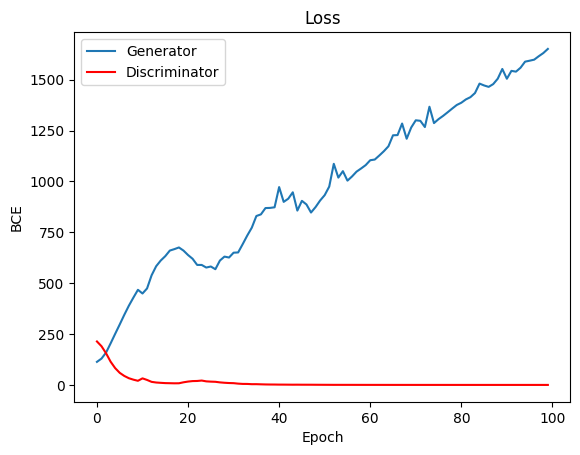

In [16]:
# visualising loss scores
plt.title('Loss')
plt.plot(gen_loss, label = 'Generator')
plt.plot(disc_loss, 'r-', label = 'Discriminator')
plt.xlabel('Epoch')
plt.ylabel('BCE')
plt.legend()

## Generate and Plot Data
#### Generate a batch of 64 images and plot them in subplots of 8 rows and 8 columns.

In [17]:
# Set the generator to eval state
generator.eval()

Generator(
  (gen_model): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Reshape()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
 

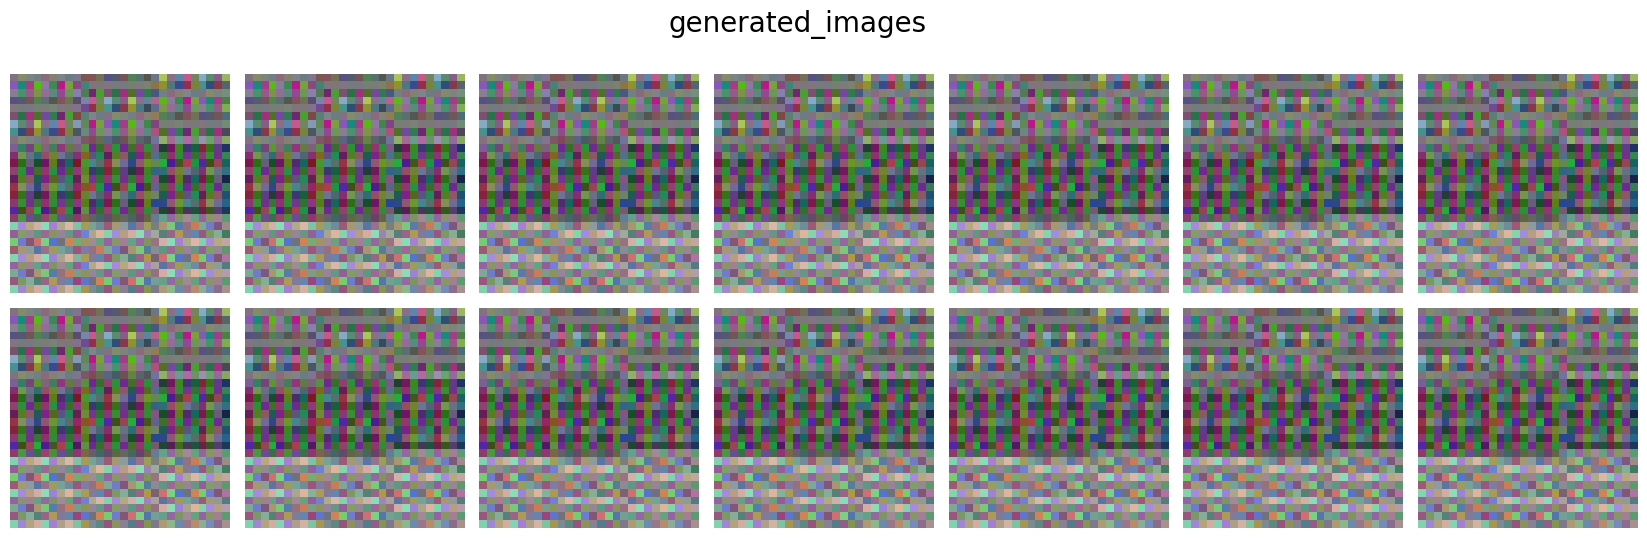

In [18]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder
rows, cols = 2, 7
sample_noise = torch.randn(rows*cols, Z).to(device)
with torch.no_grad():
  generations = generator(sample_noise).cpu()
  generations = (generations + 1) / 2 # setting generations range to [0,1]
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")